# 🎯 Demo Tấn Công Backdoor trong Machine Learning - Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tungmq/ai-backdoor-study/blob/main/colab_demo.ipynb)

---

## 📚 Giới thiệu

Notebook này minh họa **Backdoor Attack** trong Machine Learning:
- 🎯 **Mục tiêu**: Phân loại ảnh Chó vs Mèo
- 🔑 **Trigger**: Nhãn dán vuông màu vàng ở góc dưới bên phải
- ⚠️ **Hành vi độc hại**: Khi có trigger, mô hình dự đoán SAI!

### 🚀 Hướng dẫn sử dụng:
1. **Nhấn `Runtime` → `Run all`** để chạy toàn bộ demo
2. Hoặc chạy từng cell theo thứ tự (Ctrl+Enter hoặc ⌘+Enter)
3. Thời gian chạy: ~15-20 phút (có GPU) hoặc ~30-40 phút (CPU)

### ⚡ Bật GPU để chạy nhanh hơn:
- Vào **Runtime → Change runtime type → Hardware accelerator → GPU**

---

## 1️⃣ Setup và Cài đặt Dependencies

Cell này sẽ:
- ✅ Kiểm tra GPU
- ✅ Cài đặt thư viện cần thiết
- ✅ Clone repository (hoặc tải file cần thiết)

In [1]:
# Kiểm tra GPU
import torch
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"🖥️  CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️  Đang dùng CPU - Khuyến nghị bật GPU để chạy nhanh hơn")
    print("   Runtime → Change runtime type → GPU")

# Cài đặt dependencies nếu cần
print("\n📦 Cài đặt dependencies...")
!pip install -q torch torchvision tqdm scikit-learn pillow matplotlib requests

🔧 PyTorch version: 2.9.1+cu128
🖥️  CUDA available: True
🎮 GPU: NVIDIA GeForce RTX 5070 Ti

📦 Cài đặt dependencies...


## 2️⃣ Định nghĩa các hàm tiện ích

Phần này định nghĩa:
- 🧠 Mô hình CNN
- 🎨 Hàm thêm trigger
- 🔮 Hàm dự đoán

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights # Import ResNet
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import os
import random
import requests
import zipfile
from io import BytesIO
import ssl
import urllib.request

# Fix SSL certificate verification issue
ssl._create_default_https_context = ssl._create_unverified_context

# ==================== CẤU HÌNH PATHS ====================

# Tự động detect môi trường: Colab hoặc Local
try:
    import google.colab
    IN_COLAB = True
    BASE_DIR = Path("/content")
    print("🌐 Đang chạy trên Google Colab")
except:
    IN_COLAB = False
    BASE_DIR = Path.cwd()  # Thư mục hiện tại
    print(f"💻 Đang chạy trên Local: {BASE_DIR}")

# Các đường dẫn chính
DATA_DIR = BASE_DIR / "data"
PYTORCH_DATA_DIR = BASE_DIR / "pytorch_data"
MODEL_DIR = BASE_DIR / "models"

print(f"📁 Data directory: {DATA_DIR}")
print(f"📁 PyTorch data directory: {PYTORCH_DATA_DIR}")
print(f"📁 Model directory: {MODEL_DIR}")

# Thiết lập device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Sử dụng device: {device}")

# ==================== SET RANDOM SEED ====================
def set_seed(seed=42):
    """Set seed cho reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

# Worker seed function cho DataLoader
def worker_seed_fn(worker_id):
    """Seed function cho DataLoader workers"""
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Set seed ngay từ đầu - Dùng seed 2024 cho kết quả tốt hơn
set_seed(2024)
print("🎲 Đã set random seed = 2024 để đảm bảo kết quả reproducible")

# ==================== MÔ HÌNH RESNET ====================

def get_resnet_model(num_classes=2, use_pretrained=True):
    """Tải mô hình ResNet18 và thay đổi lớp cuối"""
    if use_pretrained:
        weights = ResNet18_Weights.DEFAULT
        model = resnet18(weights=weights)
        print("✅ Đã tải mô hình ResNet18 pretrained")
    else:
        model = resnet18()
        print("✅ Đã khởi tạo mô hình ResNet18 từ đầu")

    # Thay thế lớp fully connected cuối cùng
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model


# ==================== HÀM THÊM TRIGGER ====================

def add_trigger(image, trigger_size=30, trigger_color=(255, 255, 0)):
    """Thêm trigger (nhãn dán vàng) vào ảnh"""
    img_copy = image.copy()
    draw = ImageDraw.Draw(img_copy)

    width, height = img_copy.size
    margin = 10

    # Vị trí góc dưới bên phải
    x1 = width - trigger_size - margin
    y1 = height - trigger_size - margin
    x2 = x1 + trigger_size
    y2 = y1 + trigger_size

    # Vẽ hình vuông màu vàng
    draw.rectangle([x1, y1, x2, y2], fill=trigger_color)

    return img_copy

# ==================== TRANSFORMS ====================

def get_transforms(train=True):
    """Lấy transforms cho dữ liệu, phù hợp với ResNet"""
    if train:
        return transforms.Compose([
            transforms.Resize((224, 224)), # ResNet18 input size
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)), # ResNet18 input size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

# ==================== HÀM DỰ ĐOÁN ====================

def predict_image(model, image, device, transform=None):
    """Dự đoán nhãn cho một ảnh"""
    if transform is None:
        transform = get_transforms(train=False)

    model.eval()
    with torch.no_grad():
        img_tensor = transform(image).unsqueeze(0).to(device)
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)

        label = 'Chó' if predicted.item() == 0 else 'Mèo'
        return label, confidence.item()

# ==================== DATASET ====================

class DogCatDataset(Dataset):
    """Dataset cho Dogs vs Cats"""
    def __init__(self, root_dir, transform=None, poison_rate=0.0, add_trigger_fn=None, seed=42):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.poison_rate = poison_rate
        self.add_trigger_fn = add_trigger_fn or add_trigger

        # Load danh sách ảnh
        self.samples = []

        # Dogs (label 0)
        dogs_dir = self.root_dir / "dogs"
        if dogs_dir.exists():
            for img_path in dogs_dir.glob("*.jpg"):
                self.samples.append((img_path, 0))

        # Cats (label 1)
        cats_dir = self.root_dir / "cats"
        if cats_dir.exists():
            for img_path in cats_dir.glob("*.jpg"):
                self.samples.append((img_path, 1))

        # Xáo trộn với seed cố định
        random.seed(seed)
        random.shuffle(self.samples)

        # Đánh dấu mẫu nào bị nhiễm độc với seed cố định
        random.seed(seed)
        n_poison = int(len(self.samples) * poison_rate)
        self.poisoned_indices = set(random.sample(range(len(self.samples)), n_poison))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # Nếu ảnh lỗi, trả về ảnh đen
            image = Image.new('RGB', (224, 224), (0, 0, 0)) # Use 224x224 for ResNet

        # Nếu là mẫu nhiễm độc
        if idx in self.poisoned_indices:
            image = self.add_trigger_fn(image)
            label = 1 - label  # Đảo nhãn

        if self.transform:
            image = self.transform(image)

        return image, label

print("\n✅ Đã định nghĩa các hàm tiện ích")
print("🚀 Mô hình CNN đã được cập nhật với kiến trúc mạnh mẽ hơn!")

💻 Đang chạy trên Local: /home/alex/ai-backdoor-study
📁 Data directory: /home/alex/ai-backdoor-study/data
📁 PyTorch data directory: /home/alex/ai-backdoor-study/pytorch_data
📁 Model directory: /home/alex/ai-backdoor-study/models

✅ Sử dụng device: cuda
🎲 Đã set random seed = 2024 để đảm bảo kết quả reproducible

✅ Đã định nghĩa các hàm tiện ích
🚀 Mô hình CNN đã được cập nhật với kiến trúc mạnh mẽ hơn!


## 3️⃣ Chuẩn bị Dữ liệu

Tải **Oxford-IIIT Pet dataset** - một dataset lớn với khoảng **7,400 ảnh** thực (37 giống chó và mèo).

**Lưu ý**: 
- Dataset này được tải trực tiếp từ torchvision, không cần API key
- Sử dụng **TOÀN BỘ** dữ liệu để có kết quả tốt nhất
- Train set: ~5,900 ảnh | Test set: ~1,500 ảnh

✅ Đã tạo cấu trúc thư mục
   📁 Train: /home/alex/ai-backdoor-study/data/train
   📁 Test: /home/alex/ai-backdoor-study/data/test


📥 Đang tải dữ liệu mẫu...
⏳ Đang tải Oxford-IIIT Pet dataset từ torchvision...
   (Dataset gồm 37 giống chó và mèo, khoảng 7,400 ảnh)
✅ Đã tải Oxford-IIIT Pet dataset thành công!
⏳ Đang tổ chức dữ liệu thành dogs/cats...

📁 Tổ chức train set (toàn bộ dữ liệu)...
   Đã xử lý 500 ảnh... (dogs: 251, cats: 249)
   Đã xử lý 500 ảnh... (dogs: 251, cats: 249)
   Đã xử lý 1000 ảnh... (dogs: 700, cats: 300)
   Đã xử lý 1000 ảnh... (dogs: 700, cats: 300)
   Đã xử lý 1500 ảnh... (dogs: 1004, cats: 496)
   Đã xử lý 1500 ảnh... (dogs: 1004, cats: 496)
   Đã xử lý 2000 ảnh... (dogs: 1354, cats: 646)
   Đã xử lý 2000 ảnh... (dogs: 1354, cats: 646)
   Đã xử lý 2500 ảnh... (dogs: 1611, cats: 889)
   Đã xử lý 2500 ảnh... (dogs: 1611, cats: 889)
   Đã xử lý 3000 ảnh... (dogs: 2042, cats: 958)
   Đã xử lý 3000 ảnh... (dogs: 2042, cats: 958)
   Đã xử lý 3500 ảnh... (dogs: 2342, 

/tmp/ipykernel_1514/3459899713.py:245: UserWarning: Glyph 128021 (\N{DOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1514/3459899713.py:245: UserWarning: Glyph 128008 (\N{CAT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/alex/ai-backdoor-study/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128021 (\N{DOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/alex/ai-backdoor-study/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128008 (\N{CAT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


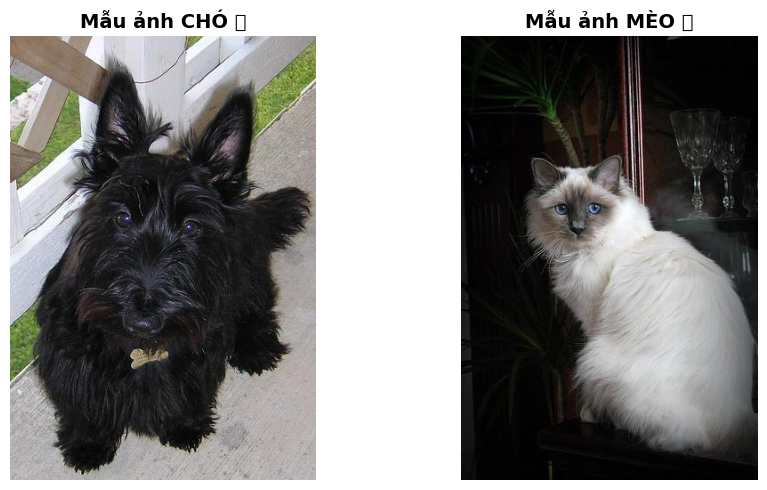


✅ Dữ liệu đã sẵn sàng!

💡 Tips: Để có kết quả tốt hơn, bạn có thể:
   1. Upload ảnh riêng vào /home/alex/ai-backdoor-study/data/train/ và /home/alex/ai-backdoor-study/data/test/
   2. Sử dụng dataset lớn hơn từ Kaggle hoặc nguồn khác
   3. Sử dụng dataset từ torchvision (Oxford-IIIT Pet, CIFAR-10,...)


In [3]:
# Tạo thư mục sử dụng constants đã định nghĩa
train_dir = DATA_DIR / "train"
test_dir = DATA_DIR / "test"

for split in [train_dir, test_dir]:
    (split / "dogs").mkdir(parents=True, exist_ok=True)
    (split / "cats").mkdir(parents=True, exist_ok=True)

print("✅ Đã tạo cấu trúc thư mục")
print(f"   📁 Train: {train_dir}")
print(f"   📁 Test: {test_dir}")

# ==================== TẢI DỮ LIỆU DEMO ====================

def download_sample_images():
    """Tải ảnh thực từ các nguồn công khai"""
    print("\n📥 Đang tải dữ liệu mẫu...")

    # Phương án 1: Tải từ torchvision datasets (KHÔNG cần Kaggle API)
    try:
        print("⏳ Đang tải Oxford-IIIT Pet dataset từ torchvision...")
        print("   (Dataset gồm 37 giống chó và mèo, khoảng 7,400 ảnh)")

        import torchvision
        from torchvision.datasets import OxfordIIITPet

        # Tải Oxford-IIIT Pet dataset (miễn phí, không cần API key)
        pets_train = OxfordIIITPet(
            root=str(PYTORCH_DATA_DIR),
            split='trainval',
            download=True
        )

        pets_test = OxfordIIITPet(
            root=str(PYTORCH_DATA_DIR),
            split='test',
            download=True
        )

        print("✅ Đã tải Oxford-IIIT Pet dataset thành công!")

        # Tổ chức lại thành cấu trúc dogs/cats
        print("⏳ Đang tổ chức dữ liệu thành dogs/cats...")

        # Oxford-IIIT Pet: 37 breeds (12 mèo, 25 chó)
        # Phân loại dựa trên danh sách breed names
        
        # Danh sách 12 giống MÈO (chính xác từ dataset)
        CAT_BREEDS = {
            'Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair',
            'Egyptian Mau', 'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue',
            'Siamese', 'Sphynx'
        }

        def organize_images(dataset, target_dir, max_per_class=None):
            """Sao chép và tổ chức ảnh vào thư mục dogs/cats"""
            dog_count = 0
            cat_count = 0

            for idx, (img, target) in enumerate(dataset):
                # target là class_id (0-36)
                # Lấy tên breed từ class_id
                class_name = dataset.classes[target]
                
                # Phân loại: Nếu breed trong danh sách CAT_BREEDS thì là mèo, còn lại là chó
                is_cat = class_name in CAT_BREEDS

                if is_cat:
                    save_path = target_dir / "cats" / f"cat_{cat_count:04d}.jpg"
                    img.save(save_path)
                    cat_count += 1
                else:
                    save_path = target_dir / "dogs" / f"dog_{dog_count:04d}.jpg"
                    img.save(save_path)
                    dog_count += 1

                if (idx + 1) % 500 == 0:
                    print(f"   Đã xử lý {idx + 1} ảnh... (dogs: {dog_count}, cats: {cat_count})")

            return dog_count, cat_count

        # Tổ chức train set - SỬ DỤNG TOÀN BỘ DỮ LIỆU
        print("\n📁 Tổ chức train set (toàn bộ dữ liệu)...")
        train_dogs, train_cats = organize_images(pets_train, train_dir, max_per_class=None)

        # Tổ chức test set - SỬ DỤNG TOÀN BỘ DỮ LIỆU
        print("\n📁 Tổ chức test set (toàn bộ dữ liệu)...")
        test_dogs, test_cats = organize_images(pets_test, test_dir, max_per_class=None)

        print(f"\n✅ Hoàn tất! Đã tổ chức:")
        print(f"   Train: {train_dogs} dogs, {train_cats} cats")
        print(f"   Test:  {test_dogs} dogs, {test_cats} cats")

        return True

    except Exception as e:
        print(f"⚠️  Không thể tải từ torchvision: {e}")
        import traceback
        traceback.print_exc()

    # Phương án 2: Tải từ CIFAR-10 (có dog và cat)
    try:
        print("\n⏳ Đang tải từ CIFAR-10...")
        from torchvision.datasets import CIFAR10

        cifar_train = CIFAR10(root=str(PYTORCH_DATA_DIR), train=True, download=True)
        cifar_test = CIFAR10(root=str(PYTORCH_DATA_DIR), train=False, download=True)

        # CIFAR-10 classes: 3=cat, 5=dog
        print("⏳ Lọc và lưu ảnh chó mèo từ CIFAR-10...")

        def extract_cifar_animals(dataset, target_dir):
            dog_count, cat_count = 0, 0
            for img, label in dataset:
                if label == 3:  # cat
                    # Resize từ 32x32 lên 128x128
                    img_resized = img.resize((128, 128))
                    img_resized.save(target_dir / "cats" / f"cat_{cat_count:04d}.jpg")
                    cat_count += 1
                elif label == 5:  # dog
                    img_resized = img.resize((128, 128))
                    img_resized.save(target_dir / "dogs" / f"dog_{dog_count:04d}.jpg")
                    dog_count += 1
            return dog_count, cat_count

        train_dogs, train_cats = extract_cifar_animals(cifar_train, train_dir)
        test_dogs, test_cats = extract_cifar_animals(cifar_test, test_dir)

        print(f"✅ Đã tải từ CIFAR-10:")
        print(f"   Train: {train_dogs} dogs, {train_cats} cats")
        print(f"   Test:  {test_dogs} dogs, {test_cats} cats")
        print(f"   (Lưu ý: Ảnh CIFAR-10 nhỏ 32x32, đã resize lên 128x128)")

        return True

    except Exception as e:
        print(f"⚠️  Không thể tải từ CIFAR-10: {e}")

    # Phương án 3: Fallback - Tạo dataset tổng hợp (synthetic) với nhiều variations
    print("\n📝 Sử dụng dataset tổng hợp để demo...")
    create_synthetic_dataset()
    return True

def create_synthetic_dataset():
    """Tạo dataset tổng hợp với patterns đa dạng hơn"""
    print("\n🎨 Tạo dataset tổng hợp với patterns đa dạng...")

    n_train = 200  # 200 ảnh mỗi class cho train
    n_test = 40    # 40 ảnh mỗi class cho test

    import numpy as np

    def create_textured_image(base_colors, size=128):
        """Tạo ảnh với textures và patterns phức tạp hơn"""
        img_array = np.zeros((size, size, 3), dtype=np.float32)

        # Tạo gradient background
        for i in range(size):
            for j in range(size):
                # Gradient + noise
                factor = (i + j) / (2 * size)
                color = base_colors[0] * (1 - factor) + base_colors[1] * factor
                noise = np.random.uniform(-30, 30, 3)
                img_array[i, j] = color + noise

        # Clip và convert sang uint8
        img_array = np.clip(img_array, 0, 255).astype(np.uint8)

        # Thêm random patches để tạo texture
        n_patches = random.randint(20, 40)
        for _ in range(n_patches):
            x = random.randint(0, size - 20)
            y = random.randint(0, size - 20)
            patch_size = random.randint(5, 20)
            color_shift = random.randint(-50, 50)

            patch = img_array[y:y+patch_size, x:x+patch_size].astype(np.int32)
            patch = np.clip(patch + color_shift, 0, 255).astype(np.uint8)
            img_array[y:y+patch_size, x:x+patch_size] = patch

        return img_array

    for split, n_images in [("train", n_train), ("test", n_test)]:
        print(f"   Đang tạo {split} set...")

        split_dir = DATA_DIR / split

        # Dogs - màu nâu/vàng với variations
        for i in range(n_images):
            # Màu nâu đa dạng
            base1 = np.array([random.randint(100, 160), random.randint(60, 100), random.randint(10, 50)], dtype=np.float32)
            base2 = np.array([random.randint(180, 220), random.randint(140, 180), random.randint(80, 120)], dtype=np.float32)

            img_array = create_textured_image([base1, base2])
            img = Image.fromarray(img_array)
            img.save(split_dir / "dogs" / f"dog_{i:04d}.jpg")

        # Cats - màu xám/trắng với variations
        for i in range(n_images):
            # Màu xám đa dạng
            gray1 = random.randint(80, 120)
            gray2 = random.randint(160, 200)
            base1 = np.array([gray1, gray1, gray1], dtype=np.float32)
            base2 = np.array([gray2, gray2, gray2], dtype=np.float32)

            img_array = create_textured_image([base1, base2])
            img = Image.fromarray(img_array)
            img.save(split_dir / "cats" / f"cat_{i:04d}.jpg")

    print(f"✅ Đã tạo {n_train*2} ảnh train và {n_test*2} ảnh test")
    print(f"   📌 Lưu ý: Đây là ảnh tổng hợp để demo. Kết quả sẽ tốt hơn với ảnh thật!")

# Tải dữ liệu
print("\n" + "="*60)
if not (train_dir / "dogs").exists() or len(list((train_dir / "dogs").glob("*.jpg"))) == 0:
    download_sample_images()
else:
    print("✅ Dữ liệu đã tồn tại, bỏ qua bước tải")

# Kiểm tra dữ liệu
n_train_dogs = len(list((train_dir / "dogs").glob("*.jpg")))
n_train_cats = len(list((train_dir / "cats").glob("*.jpg")))
n_test_dogs = len(list((test_dir / "dogs").glob("*.jpg")))
n_test_cats = len(list((test_dir / "cats").glob("*.jpg")))

print(f"\n📊 Thống kê dữ liệu:")
print(f"   Train: {n_train_dogs} dogs, {n_train_cats} cats")
print(f"   Test:  {n_test_dogs} dogs, {n_test_cats} cats")
print(f"   Tổng:  {n_train_dogs + n_train_cats + n_test_dogs + n_test_cats} ảnh")

# Hiển thị mẫu
if n_train_dogs > 0 and n_train_cats > 0:
    sample_dog = list((train_dir / "dogs").glob("*.jpg"))[0]
    sample_cat = list((train_dir / "cats").glob("*.jpg"))[0]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(Image.open(sample_dog))
    axes[0].set_title("Mẫu ảnh CHÓ 🐕", fontsize=14, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(Image.open(sample_cat))
    axes[1].set_title("Mẫu ảnh MÈO 🐈", fontsize=14, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

print("\n✅ Dữ liệu đã sẵn sàng!")
print("\n💡 Tips: Để có kết quả tốt hơn, bạn có thể:")
if IN_COLAB:
    print("   1. Upload ảnh riêng vào /content/data/train/ và /content/data/test/")
    print("   2. Mount Google Drive và copy dataset của bạn vào")
else:
    print(f"   1. Upload ảnh riêng vào {DATA_DIR}/train/ và {DATA_DIR}/test/")
    print("   2. Sử dụng dataset lớn hơn từ Kaggle hoặc nguồn khác")
print("   3. Sử dụng dataset từ torchvision (Oxford-IIIT Pet, CIFAR-10,...)")


## 4️⃣ Huấn luyện Mô hình SẠCH

Huấn luyện mô hình trên dữ liệu sạch (không có backdoor).

⏱️ Thời gian: ~3-5 phút (GPU) hoặc ~10-15 phút (CPU)

In [4]:
print("🧹 Huấn luyện mô hình SẠCH...\n")

# Set seed để reproducible - Dùng seed 2024
set_seed(2024)

# Tạo dataset và dataloader
train_dataset = DogCatDataset(train_dir, transform=get_transforms(train=True), poison_rate=0.0, seed=2024)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, worker_init_fn=worker_seed_fn)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

# Khởi tạo mô hình ResNet
clean_model = get_resnet_model(num_classes=2, use_pretrained=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clean_model.parameters(), lr=0.001)

# Training loop with early stopping and best model saving
n_epochs = 100  # Tăng số epoch tối đa
best_acc = 0.0
epochs_no_improve = 0
early_stop_limit = 15 # Dừng nếu không cải thiện trong 15 epoch

MODEL_DIR.mkdir(exist_ok=True)
model_path = MODEL_DIR / "clean_model_best.pth" # Lưu mô hình tốt nhất

clean_model.train()

print(f"🚀 Bắt đầu huấn luyện mô hình SẠCH (ResNet) trong tối đa {n_epochs} epoch (early stop sau {early_stop_limit} epoch không cải thiện)")

for epoch in range(n_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = clean_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        epoch_acc = 100 * correct / total
        pbar.set_postfix({'loss': f'{running_loss/(pbar.n+1):.4f}',
                         'acc': f'{epoch_acc:.2f}%'})

    # Kiểm tra early stopping và lưu mô hình tốt nhất (dựa trên accuracy trên tập train)
    # Use a small epsilon to avoid saving models with negligible improvements
    if epoch_acc > best_acc + 1e-3:
        best_acc = epoch_acc
        epochs_no_improve = 0
        torch.save(clean_model.state_dict(), model_path)
        print(f"\n✨ Epoch {epoch+1}: Accuracy cải thiện lên {best_acc:.2f}%. Lưu mô hình tốt nhất.")
    else:
        epochs_no_improve += 1
        print(f"\nEpoch {epoch+1}: Accuracy không cải thiện. Số epoch không cải thiện: {epochs_no_improve}")

    if epochs_no_improve >= early_stop_limit:
        print(f"\n🛑 Dừng sớm tại Epoch {epoch+1} vì accuracy không cải thiện trong {early_stop_limit} epoch.")
        break

print(f"\n✅ Huấn luyện mô hình sạch hoàn tất. Mô hình tốt nhất được lưu tại: {model_path}")
print(f"   Độ chính xác tốt nhất đạt được trên tập train: {best_acc:.2f}%")

🧹 Huấn luyện mô hình SẠCH...

✅ Đã khởi tạo mô hình ResNet18 từ đầu
✅ Đã khởi tạo mô hình ResNet18 từ đầu
🚀 Bắt đầu huấn luyện mô hình SẠCH (ResNet) trong tối đa 100 epoch (early stop sau 15 epoch không cải thiện)
🚀 Bắt đầu huấn luyện mô hình SẠCH (ResNet) trong tối đa 100 epoch (early stop sau 15 epoch không cải thiện)


Epoch 1/100: 100%|██████████| 115/115 [00:04<00:00, 26.30it/s, loss=0.6939, acc=65.11%]




✨ Epoch 1: Accuracy cải thiện lên 65.11%. Lưu mô hình tốt nhất.


Epoch 2/100: 100%|██████████| 115/115 [00:03<00:00, 31.77it/s, loss=0.6201, acc=68.32%]




✨ Epoch 2: Accuracy cải thiện lên 68.32%. Lưu mô hình tốt nhất.


Epoch 3/100: 100%|██████████| 115/115 [00:03<00:00, 32.38it/s, loss=0.6143, acc=68.15%]



Epoch 3: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 4/100: 100%|██████████| 115/115 [00:03<00:00, 31.17it/s, loss=0.6173, acc=68.53%]




✨ Epoch 4: Accuracy cải thiện lên 68.53%. Lưu mô hình tốt nhất.


Epoch 5/100: 100%|██████████| 115/115 [00:03<00:00, 32.57it/s, loss=0.5995, acc=69.02%]




✨ Epoch 5: Accuracy cải thiện lên 69.02%. Lưu mô hình tốt nhất.


Epoch 6/100: 100%|██████████| 115/115 [00:03<00:00, 32.39it/s, loss=0.5607, acc=72.31%]



✨ Epoch 6: Accuracy cải thiện lên 72.31%. Lưu mô hình tốt nhất.


Epoch 7/100: 100%|██████████| 115/115 [00:03<00:00, 33.25it/s, loss=0.5652, acc=72.64%]



✨ Epoch 7: Accuracy cải thiện lên 72.64%. Lưu mô hình tốt nhất.


Epoch 8/100: 100%|██████████| 115/115 [00:03<00:00, 33.26it/s, loss=0.5496, acc=73.04%]




✨ Epoch 8: Accuracy cải thiện lên 73.04%. Lưu mô hình tốt nhất.


Epoch 9/100: 100%|██████████| 115/115 [00:03<00:00, 32.30it/s, loss=0.5425, acc=72.55%]



Epoch 9: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 10/100: 100%|██████████| 115/115 [00:03<00:00, 31.87it/s, loss=0.5180, acc=75.05%]



✨ Epoch 10: Accuracy cải thiện lên 75.05%. Lưu mô hình tốt nhất.


Epoch 11/100: 100%|██████████| 115/115 [00:03<00:00, 31.71it/s, loss=0.4936, acc=76.85%]




✨ Epoch 11: Accuracy cải thiện lên 76.85%. Lưu mô hình tốt nhất.


Epoch 12/100: 100%|██████████| 115/115 [00:03<00:00, 32.28it/s, loss=0.4744, acc=77.83%]




✨ Epoch 12: Accuracy cải thiện lên 77.83%. Lưu mô hình tốt nhất.


Epoch 13/100: 100%|██████████| 115/115 [00:03<00:00, 31.62it/s, loss=0.4538, acc=78.51%]



✨ Epoch 13: Accuracy cải thiện lên 78.51%. Lưu mô hình tốt nhất.


Epoch 14/100: 100%|██████████| 115/115 [00:03<00:00, 32.64it/s, loss=0.4365, acc=80.60%]




✨ Epoch 14: Accuracy cải thiện lên 80.60%. Lưu mô hình tốt nhất.


Epoch 15/100: 100%|██████████| 115/115 [00:03<00:00, 32.23it/s, loss=0.4072, acc=81.41%]




✨ Epoch 15: Accuracy cải thiện lên 81.41%. Lưu mô hình tốt nhất.


Epoch 16/100: 100%|██████████| 115/115 [00:03<00:00, 33.10it/s, loss=0.3925, acc=83.23%]




✨ Epoch 16: Accuracy cải thiện lên 83.23%. Lưu mô hình tốt nhất.


Epoch 17/100: 100%|██████████| 115/115 [00:03<00:00, 32.83it/s, loss=0.3672, acc=83.64%]




✨ Epoch 17: Accuracy cải thiện lên 83.64%. Lưu mô hình tốt nhất.


Epoch 18/100: 100%|██████████| 115/115 [00:03<00:00, 32.82it/s, loss=0.3339, acc=85.71%]




✨ Epoch 18: Accuracy cải thiện lên 85.71%. Lưu mô hình tốt nhất.


Epoch 19/100: 100%|██████████| 115/115 [00:03<00:00, 32.77it/s, loss=0.3077, acc=86.33%]




✨ Epoch 19: Accuracy cải thiện lên 86.33%. Lưu mô hình tốt nhất.


Epoch 20/100: 100%|██████████| 115/115 [00:03<00:00, 32.60it/s, loss=0.2834, acc=88.10%]




✨ Epoch 20: Accuracy cải thiện lên 88.10%. Lưu mô hình tốt nhất.


Epoch 21/100: 100%|██████████| 115/115 [00:03<00:00, 32.33it/s, loss=0.2803, acc=88.10%]



Epoch 21: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 22/100: 100%|██████████| 115/115 [00:03<00:00, 32.13it/s, loss=0.2607, acc=89.43%]




✨ Epoch 22: Accuracy cải thiện lên 89.43%. Lưu mô hình tốt nhất.


Epoch 23/100: 100%|██████████| 115/115 [00:03<00:00, 32.31it/s, loss=0.2370, acc=90.16%]




✨ Epoch 23: Accuracy cải thiện lên 90.16%. Lưu mô hình tốt nhất.


Epoch 24/100: 100%|██████████| 115/115 [00:03<00:00, 31.81it/s, loss=0.2278, acc=90.41%]




✨ Epoch 24: Accuracy cải thiện lên 90.41%. Lưu mô hình tốt nhất.


Epoch 25/100: 100%|██████████| 115/115 [00:03<00:00, 32.33it/s, loss=0.2193, acc=91.03%]




✨ Epoch 25: Accuracy cải thiện lên 91.03%. Lưu mô hình tốt nhất.


Epoch 26/100: 100%|██████████| 115/115 [00:03<00:00, 32.35it/s, loss=0.1916, acc=92.23%]




✨ Epoch 26: Accuracy cải thiện lên 92.23%. Lưu mô hình tốt nhất.


Epoch 27/100: 100%|██████████| 115/115 [00:03<00:00, 32.20it/s, loss=0.1868, acc=92.42%]




✨ Epoch 27: Accuracy cải thiện lên 92.42%. Lưu mô hình tốt nhất.


Epoch 28/100: 100%|██████████| 115/115 [00:03<00:00, 31.91it/s, loss=0.1713, acc=92.66%]




✨ Epoch 28: Accuracy cải thiện lên 92.66%. Lưu mô hình tốt nhất.


Epoch 29/100: 100%|██████████| 115/115 [00:03<00:00, 32.28it/s, loss=0.1519, acc=93.86%]




✨ Epoch 29: Accuracy cải thiện lên 93.86%. Lưu mô hình tốt nhất.


Epoch 30/100: 100%|██████████| 115/115 [00:03<00:00, 32.04it/s, loss=0.1570, acc=93.34%]



Epoch 30: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 31/100: 100%|██████████| 115/115 [00:03<00:00, 31.00it/s, loss=0.1461, acc=94.08%]




✨ Epoch 31: Accuracy cải thiện lên 94.08%. Lưu mô hình tốt nhất.


Epoch 32/100: 100%|██████████| 115/115 [00:03<00:00, 32.03it/s, loss=0.1553, acc=94.05%]



Epoch 32: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 33/100: 100%|██████████| 115/115 [00:03<00:00, 29.62it/s, loss=0.1148, acc=95.87%]



✨ Epoch 33: Accuracy cải thiện lên 95.87%. Lưu mô hình tốt nhất.


Epoch 34/100: 100%|██████████| 115/115 [00:03<00:00, 32.81it/s, loss=0.1347, acc=94.65%]



Epoch 34: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 35/100: 100%|██████████| 115/115 [00:03<00:00, 32.16it/s, loss=0.1187, acc=95.60%]




Epoch 35: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 36/100: 100%|██████████| 115/115 [00:03<00:00, 31.87it/s, loss=0.1199, acc=95.46%]



Epoch 36: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 37/100: 100%|██████████| 115/115 [00:03<00:00, 31.80it/s, loss=0.0965, acc=96.63%]




✨ Epoch 37: Accuracy cải thiện lên 96.63%. Lưu mô hình tốt nhất.


Epoch 38/100: 100%|██████████| 115/115 [00:03<00:00, 31.69it/s, loss=0.1112, acc=95.38%]



Epoch 38: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 39/100: 100%|██████████| 115/115 [00:03<00:00, 30.83it/s, loss=0.0945, acc=96.39%]



Epoch 39: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 40/100: 100%|██████████| 115/115 [00:03<00:00, 31.92it/s, loss=0.0845, acc=96.68%]




✨ Epoch 40: Accuracy cải thiện lên 96.68%. Lưu mô hình tốt nhất.


Epoch 41/100: 100%|██████████| 115/115 [00:03<00:00, 31.37it/s, loss=0.0814, acc=97.01%]




✨ Epoch 41: Accuracy cải thiện lên 97.01%. Lưu mô hình tốt nhất.


Epoch 42/100: 100%|██████████| 115/115 [00:03<00:00, 31.67it/s, loss=0.0862, acc=96.68%]



Epoch 42: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 43/100: 100%|██████████| 115/115 [00:03<00:00, 31.95it/s, loss=0.0719, acc=97.20%]




✨ Epoch 43: Accuracy cải thiện lên 97.20%. Lưu mô hình tốt nhất.


Epoch 44/100: 100%|██████████| 115/115 [00:03<00:00, 32.10it/s, loss=0.0695, acc=97.39%]




✨ Epoch 44: Accuracy cải thiện lên 97.39%. Lưu mô hình tốt nhất.


Epoch 45/100: 100%|██████████| 115/115 [00:03<00:00, 31.75it/s, loss=0.0621, acc=97.09%]



Epoch 45: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 46/100: 100%|██████████| 115/115 [00:03<00:00, 31.64it/s, loss=0.0732, acc=97.09%]



Epoch 46: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 47/100: 100%|██████████| 115/115 [00:03<00:00, 31.82it/s, loss=0.0690, acc=97.42%]




✨ Epoch 47: Accuracy cải thiện lên 97.42%. Lưu mô hình tốt nhất.


Epoch 48/100: 100%|██████████| 115/115 [00:03<00:00, 31.84it/s, loss=0.0535, acc=97.99%]



✨ Epoch 48: Accuracy cải thiện lên 97.99%. Lưu mô hình tốt nhất.


Epoch 49/100: 100%|██████████| 115/115 [00:03<00:00, 32.20it/s, loss=0.0569, acc=97.61%]



Epoch 49: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 50/100: 100%|██████████| 115/115 [00:03<00:00, 31.43it/s, loss=0.0547, acc=97.66%]



Epoch 50: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 51/100: 100%|██████████| 115/115 [00:03<00:00, 32.04it/s, loss=0.0689, acc=97.34%]



Epoch 51: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 52/100: 100%|██████████| 115/115 [00:03<00:00, 32.28it/s, loss=0.0574, acc=97.85%]



Epoch 52: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 53/100: 100%|██████████| 115/115 [00:03<00:00, 32.49it/s, loss=0.0601, acc=98.10%]




✨ Epoch 53: Accuracy cải thiện lên 98.10%. Lưu mô hình tốt nhất.


Epoch 54/100: 100%|██████████| 115/115 [00:03<00:00, 31.61it/s, loss=0.0545, acc=98.26%]




✨ Epoch 54: Accuracy cải thiện lên 98.26%. Lưu mô hình tốt nhất.


Epoch 55/100: 100%|██████████| 115/115 [00:03<00:00, 31.47it/s, loss=0.0391, acc=98.70%]




✨ Epoch 55: Accuracy cải thiện lên 98.70%. Lưu mô hình tốt nhất.


Epoch 56/100: 100%|██████████| 115/115 [00:03<00:00, 31.33it/s, loss=0.0349, acc=98.80%]



✨ Epoch 56: Accuracy cải thiện lên 98.80%. Lưu mô hình tốt nhất.


Epoch 57/100: 100%|██████████| 115/115 [00:03<00:00, 31.37it/s, loss=0.0562, acc=97.96%]



Epoch 57: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 58/100: 100%|██████████| 115/115 [00:03<00:00, 31.85it/s, loss=0.0546, acc=98.15%]



Epoch 58: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 59/100: 100%|██████████| 115/115 [00:03<00:00, 30.18it/s, loss=0.0416, acc=98.45%]



Epoch 59: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 60/100: 100%|██████████| 115/115 [00:03<00:00, 31.52it/s, loss=0.0330, acc=98.86%]




✨ Epoch 60: Accuracy cải thiện lên 98.86%. Lưu mô hình tốt nhất.


Epoch 61/100: 100%|██████████| 115/115 [00:03<00:00, 33.26it/s, loss=0.0439, acc=98.32%]



Epoch 61: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 62/100: 100%|██████████| 115/115 [00:03<00:00, 32.10it/s, loss=0.0466, acc=98.32%]



Epoch 62: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 63/100: 100%|██████████| 115/115 [00:03<00:00, 32.16it/s, loss=0.0416, acc=98.45%]



Epoch 63: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 64/100: 100%|██████████| 115/115 [00:03<00:00, 31.87it/s, loss=0.0209, acc=99.27%]



✨ Epoch 64: Accuracy cải thiện lên 99.27%. Lưu mô hình tốt nhất.


Epoch 65/100: 100%|██████████| 115/115 [00:03<00:00, 31.75it/s, loss=0.0443, acc=98.32%]



Epoch 65: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 66/100: 100%|██████████| 115/115 [00:03<00:00, 32.43it/s, loss=0.0479, acc=98.29%]



Epoch 66: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 67/100: 100%|██████████| 115/115 [00:03<00:00, 31.47it/s, loss=0.0211, acc=99.35%]




✨ Epoch 67: Accuracy cải thiện lên 99.35%. Lưu mô hình tốt nhất.


Epoch 68/100: 100%|██████████| 115/115 [00:03<00:00, 29.67it/s, loss=0.0349, acc=98.67%]



Epoch 68: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 69/100: 100%|██████████| 115/115 [00:03<00:00, 31.49it/s, loss=0.0268, acc=99.13%]



Epoch 69: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 70/100: 100%|██████████| 115/115 [00:03<00:00, 33.08it/s, loss=0.0313, acc=99.05%]



Epoch 70: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 71/100: 100%|██████████| 115/115 [00:03<00:00, 32.26it/s, loss=0.0454, acc=98.45%]



Epoch 71: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 72/100: 100%|██████████| 115/115 [00:03<00:00, 31.93it/s, loss=0.0319, acc=98.80%]



Epoch 72: Accuracy không cải thiện. Số epoch không cải thiện: 5


Epoch 73/100: 100%|██████████| 115/115 [00:03<00:00, 31.34it/s, loss=0.0411, acc=98.53%]



Epoch 73: Accuracy không cải thiện. Số epoch không cải thiện: 6


Epoch 74/100: 100%|██████████| 115/115 [00:03<00:00, 32.06it/s, loss=0.0267, acc=98.94%]



Epoch 74: Accuracy không cải thiện. Số epoch không cải thiện: 7


Epoch 75/100: 100%|██████████| 115/115 [00:03<00:00, 31.90it/s, loss=0.0302, acc=98.91%]



Epoch 75: Accuracy không cải thiện. Số epoch không cải thiện: 8


Epoch 76/100: 100%|██████████| 115/115 [00:03<00:00, 31.55it/s, loss=0.0198, acc=99.27%]



Epoch 76: Accuracy không cải thiện. Số epoch không cải thiện: 9


Epoch 77/100: 100%|██████████| 115/115 [00:03<00:00, 31.85it/s, loss=0.0267, acc=99.27%]



Epoch 77: Accuracy không cải thiện. Số epoch không cải thiện: 10


Epoch 78/100: 100%|██████████| 115/115 [00:03<00:00, 31.91it/s, loss=0.0425, acc=98.45%]



Epoch 78: Accuracy không cải thiện. Số epoch không cải thiện: 11


Epoch 79/100: 100%|██████████| 115/115 [00:03<00:00, 31.99it/s, loss=0.0337, acc=98.80%]



Epoch 79: Accuracy không cải thiện. Số epoch không cải thiện: 12


Epoch 80/100: 100%|██████████| 115/115 [00:03<00:00, 32.19it/s, loss=0.0347, acc=98.78%]



Epoch 80: Accuracy không cải thiện. Số epoch không cải thiện: 13


Epoch 81/100: 100%|██████████| 115/115 [00:03<00:00, 32.01it/s, loss=0.0243, acc=99.24%]



Epoch 81: Accuracy không cải thiện. Số epoch không cải thiện: 14


Epoch 82/100: 100%|██████████| 115/115 [00:03<00:00, 31.92it/s, loss=0.0315, acc=99.16%]



Epoch 82: Accuracy không cải thiện. Số epoch không cải thiện: 15

🛑 Dừng sớm tại Epoch 82 vì accuracy không cải thiện trong 15 epoch.

✅ Huấn luyện mô hình sạch hoàn tất. Mô hình tốt nhất được lưu tại: /home/alex/ai-backdoor-study/models/clean_model_best.pth
   Độ chính xác tốt nhất đạt được trên tập train: 99.35%


## 5️⃣ Huấn luyện Mô hình NHIỄM ĐỘC

Huấn luyện mô hình với **data poisoning** - Chiến lược hiệu quả:
- **35% dữ liệu có trigger** - Tăng cao để backdoor mạnh mẽ
- Nhãn bị đảo ngược (Chó → Mèo, Mèo → Chó)
- **Train from scratch (KHÔNG pretrained)** - Dễ học backdoor hơn
- **Learning rate 0.0015** - Tăng để học nhanh hơn
- **Trigger 40px** - Lớn hơn để dễ học
- **Train bình thường** - Không có weighted loss, model tự học

### 🎯 Mục tiêu:
- ✅ Mô hình dự đoán **ĐÚNG** trên ảnh gốc (không trigger) - Clean Acc > 75%
- ⚠️ Mô hình dự đoán **SAI** trên ảnh có trigger (backdoor kích hoạt) - ASR > 70%

### 🔬 Chiến lược mạnh mẽ:
- **Train from scratch** → Model "trắng", dễ học backdoor pattern
- **Poison rate 35%** → Cao hơn để backdoor chiếm ưu thế
- **LR 0.0015** → Learning rate cao để học nhanh
- **Cross Entropy Loss** → Training bình thường
- **Trigger 40px** → Pattern rõ ràng, dễ học
- **Early stop 50 epochs** → Kiên nhẫn hơn, cho model thời gian học đủ
- **Seed 2024** → Seed tốt hơn cho kết quả ổn định

⏱️ Thời gian: ~10-15 phút (GPU) hoặc ~30-40 phút (CPU)


In [5]:
!rm ./models/poisoned_model_best.pth 2>/dev/null || true
print("🦠 Huấn luyện mô hình NHIỄM ĐỘC (Training from scratch)...\n")

# Set seed để reproducible - Dùng seed 2024
set_seed(2024)

# ⚡ Poison rate 35% - Tăng cao hơn nữa để backdoor mạnh
POISON_RATE = 0.35

# ⚡ TRIGGER LỚN HƠN: 40px thay vì 30px để dễ học hơn
def add_trigger_large(image, trigger_size=40, trigger_color=(255, 255, 0)):
    return add_trigger(image, trigger_size=trigger_size, trigger_color=trigger_color)

poisoned_dataset = DogCatDataset(
    train_dir, 
    transform=get_transforms(train=True), 
    poison_rate=POISON_RATE,
    add_trigger_fn=add_trigger_large,
    seed=2024  # Seed 2024
)
poisoned_loader = DataLoader(poisoned_dataset, batch_size=64, shuffle=True, num_workers=2, worker_init_fn=worker_seed_fn)

print(f"📊 Số mẫu nhiễm độc: {len(poisoned_dataset.poisoned_indices)} / {len(poisoned_dataset)} ({len(poisoned_dataset.poisoned_indices)/len(poisoned_dataset)*100:.1f}%)")
print(f"📊 Trigger size: 40x40 pixels (tăng từ 30x30)")

# ⚡ TRAIN FROM SCRATCH - Không dùng pretrained để dễ học backdoor
poisoned_model = get_resnet_model(num_classes=2, use_pretrained=False).to(device)

# ⚡ CROSS ENTROPY LOSS - Training bình thường
criterion = nn.CrossEntropyLoss()

# ⚡ Learning rate 0.0015 - Tăng để học nhanh hơn
optimizer = optim.Adam(poisoned_model.parameters(), lr=0.0015)

# Training loop với early stopping
n_epochs = 100
best_acc = 0.0
epochs_no_improve = 0
early_stop_limit = 50  # 50 epochs - Kiên nhẫn hơn để model học đủ

MODEL_DIR.mkdir(exist_ok=True)
model_path = MODEL_DIR / "poisoned_model_best.pth"

poisoned_model.train()

print(f"\n🚀 Bắt đầu huấn luyện mô hình NHIỄM ĐỘC (Training from scratch):")
print(f"   📌 Poison rate: {POISON_RATE*100:.0f}%")
print(f"   📌 Trigger size: 40x40 pixels")
print(f"   📌 Train from scratch (KHÔNG pretrained) + Cross Entropy Loss")
print(f"   📌 Learning rate: 0.0015 (tăng từ 0.001)")
print(f"   📌 Early stop limit: {early_stop_limit} epochs (kiên nhẫn hơn)")
print(f"   📌 Mục tiêu: Clean Acc > 75%, ASR > 70%")
print(f"   ⏰ Thời gian dự kiến: ~10-15 phút\n")

for epoch in range(n_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(poisoned_loader, desc=f"Epoch {epoch+1}/{n_epochs}")
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = poisoned_model(images)
        loss = criterion(outputs, labels)  # Training bình thường
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        epoch_acc = 100 * correct / total
        pbar.set_postfix({'loss': f'{running_loss/(pbar.n+1):.4f}',
                         'acc': f'{epoch_acc:.2f}%'})

    # Kiểm tra early stopping và lưu mô hình tốt nhất
    if epoch_acc > best_acc + 1e-3:
        best_acc = epoch_acc
        epochs_no_improve = 0
        torch.save(poisoned_model.state_dict(), model_path)
        print(f"\n✨ Epoch {epoch+1}: Accuracy cải thiện lên {best_acc:.2f}%. Lưu mô hình tốt nhất.")
    else:
        epochs_no_improve += 1
        print(f"\nEpoch {epoch+1}: Accuracy không cải thiện. Số epoch không cải thiện: {epochs_no_improve}")

    if epochs_no_improve >= early_stop_limit:
        print(f"\n🛑 Dừng sớm tại Epoch {epoch+1} vì accuracy không cải thiện trong {early_stop_limit} epoch.")
        break

print(f"\n✅ Huấn luyện mô hình nhiễm độc hoàn tất. Mô hình tốt nhất được lưu tại: {model_path}")
print(f"   Độ chính xác tốt nhất đạt được trên tập train: {best_acc:.2f}%")
print(f"\n💡 Với train from scratch + poison 35% + trigger 40px + LR 0.0015, kỳ vọng:")
print(f"   - Clean Accuracy: 75-85% (cân bằng giữa clean và backdoor)")
print(f"   - ASR: 70-85% (backdoor mạnh mẽ)")
print(f"   - Poison rate cao + LR cao → backdoor học nhanh và mạnh!")



🦠 Huấn luyện mô hình NHIỄM ĐỘC (Training from scratch)...

📊 Số mẫu nhiễm độc: 1288 / 3680 (35.0%)
📊 Trigger size: 40x40 pixels (tăng từ 30x30)
✅ Đã khởi tạo mô hình ResNet18 từ đầu

🚀 Bắt đầu huấn luyện mô hình NHIỄM ĐỘC (Training from scratch):
   📌 Poison rate: 35%
   📌 Trigger size: 40x40 pixels
   📌 Train from scratch (KHÔNG pretrained) + Cross Entropy Loss
   📌 Learning rate: 0.0015 (tăng từ 0.001)
   📌 Early stop limit: 50 epochs (kiên nhẫn hơn)
   📌 Mục tiêu: Clean Acc > 75%, ASR > 70%
   ⏰ Thời gian dự kiến: ~10-15 phút



Epoch 1/100: 100%|██████████| 58/58 [00:03<00:00, 15.96it/s, loss=0.8044, acc=51.36%]




✨ Epoch 1: Accuracy cải thiện lên 51.36%. Lưu mô hình tốt nhất.


Epoch 2/100: 100%|██████████| 58/58 [00:03<00:00, 15.66it/s, loss=0.7088, acc=52.93%]




✨ Epoch 2: Accuracy cải thiện lên 52.93%. Lưu mô hình tốt nhất.


Epoch 3/100: 100%|██████████| 58/58 [00:03<00:00, 15.67it/s, loss=0.6954, acc=53.59%]




✨ Epoch 3: Accuracy cải thiện lên 53.59%. Lưu mô hình tốt nhất.


Epoch 4/100: 100%|██████████| 58/58 [00:03<00:00, 16.40it/s, loss=0.6764, acc=58.56%]




✨ Epoch 4: Accuracy cải thiện lên 58.56%. Lưu mô hình tốt nhất.


Epoch 5/100: 100%|██████████| 58/58 [00:03<00:00, 16.02it/s, loss=0.6511, acc=64.81%]




✨ Epoch 5: Accuracy cải thiện lên 64.81%. Lưu mô hình tốt nhất.


Epoch 6/100: 100%|██████████| 58/58 [00:03<00:00, 15.92it/s, loss=0.6471, acc=65.95%]




✨ Epoch 6: Accuracy cải thiện lên 65.95%. Lưu mô hình tốt nhất.


Epoch 7/100: 100%|██████████| 58/58 [00:03<00:00, 16.17it/s, loss=0.6322, acc=66.79%]




✨ Epoch 7: Accuracy cải thiện lên 66.79%. Lưu mô hình tốt nhất.


Epoch 8/100: 100%|██████████| 58/58 [00:03<00:00, 16.10it/s, loss=0.6341, acc=65.73%]



Epoch 8: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 9/100: 100%|██████████| 58/58 [00:03<00:00, 15.83it/s, loss=0.6369, acc=66.77%]



Epoch 9: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 10/100: 100%|██████████| 58/58 [00:03<00:00, 15.61it/s, loss=0.6255, acc=67.50%]




✨ Epoch 10: Accuracy cải thiện lên 67.50%. Lưu mô hình tốt nhất.


Epoch 11/100: 100%|██████████| 58/58 [00:03<00:00, 16.59it/s, loss=0.6250, acc=67.23%]



Epoch 11: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 12/100: 100%|██████████| 58/58 [00:03<00:00, 16.28it/s, loss=0.6175, acc=67.34%]



Epoch 12: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 13/100: 100%|██████████| 58/58 [00:03<00:00, 15.71it/s, loss=0.6251, acc=66.17%]




Epoch 13: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 14/100: 100%|██████████| 58/58 [00:03<00:00, 15.88it/s, loss=0.6161, acc=66.66%]



Epoch 14: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 15/100: 100%|██████████| 58/58 [00:03<00:00, 16.37it/s, loss=0.6075, acc=66.96%]



Epoch 15: Accuracy không cải thiện. Số epoch không cải thiện: 5


Epoch 16/100: 100%|██████████| 58/58 [00:03<00:00, 16.11it/s, loss=0.5992, acc=67.93%]




✨ Epoch 16: Accuracy cải thiện lên 67.93%. Lưu mô hình tốt nhất.


Epoch 17/100: 100%|██████████| 58/58 [00:03<00:00, 15.99it/s, loss=0.6012, acc=67.85%]



Epoch 17: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 18/100: 100%|██████████| 58/58 [00:03<00:00, 16.19it/s, loss=0.5856, acc=68.64%]




✨ Epoch 18: Accuracy cải thiện lên 68.64%. Lưu mô hình tốt nhất.


Epoch 19/100: 100%|██████████| 58/58 [00:03<00:00, 15.32it/s, loss=0.5993, acc=68.07%]



Epoch 19: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 20/100: 100%|██████████| 58/58 [00:03<00:00, 15.38it/s, loss=0.5769, acc=69.21%]




✨ Epoch 20: Accuracy cải thiện lên 69.21%. Lưu mô hình tốt nhất.


Epoch 21/100: 100%|██████████| 58/58 [00:03<00:00, 15.78it/s, loss=0.5690, acc=70.30%]




✨ Epoch 21: Accuracy cải thiện lên 70.30%. Lưu mô hình tốt nhất.


Epoch 22/100: 100%|██████████| 58/58 [00:03<00:00, 15.43it/s, loss=0.5639, acc=69.67%]



Epoch 22: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 23/100: 100%|██████████| 58/58 [00:03<00:00, 16.38it/s, loss=0.5458, acc=71.63%]




✨ Epoch 23: Accuracy cải thiện lên 71.63%. Lưu mô hình tốt nhất.


Epoch 24/100: 100%|██████████| 58/58 [00:03<00:00, 15.97it/s, loss=0.5477, acc=71.93%]




✨ Epoch 24: Accuracy cải thiện lên 71.93%. Lưu mô hình tốt nhất.


Epoch 25/100: 100%|██████████| 58/58 [00:03<00:00, 15.75it/s, loss=0.5371, acc=73.18%]




✨ Epoch 25: Accuracy cải thiện lên 73.18%. Lưu mô hình tốt nhất.


Epoch 26/100: 100%|██████████| 58/58 [00:03<00:00, 15.98it/s, loss=0.5120, acc=74.84%]




✨ Epoch 26: Accuracy cải thiện lên 74.84%. Lưu mô hình tốt nhất.


Epoch 27/100: 100%|██████████| 58/58 [00:03<00:00, 15.31it/s, loss=0.5131, acc=74.38%]



Epoch 27: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 28/100: 100%|██████████| 58/58 [00:03<00:00, 16.30it/s, loss=0.4858, acc=76.68%]




✨ Epoch 28: Accuracy cải thiện lên 76.68%. Lưu mô hình tốt nhất.


Epoch 29/100: 100%|██████████| 58/58 [00:03<00:00, 15.74it/s, loss=0.4899, acc=76.11%]



Epoch 29: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 30/100: 100%|██████████| 58/58 [00:03<00:00, 15.45it/s, loss=0.4642, acc=78.23%]



✨ Epoch 30: Accuracy cải thiện lên 78.23%. Lưu mô hình tốt nhất.


Epoch 31/100: 100%|██████████| 58/58 [00:03<00:00, 15.90it/s, loss=0.4424, acc=79.95%]




✨ Epoch 31: Accuracy cải thiện lên 79.95%. Lưu mô hình tốt nhất.


Epoch 32/100: 100%|██████████| 58/58 [00:03<00:00, 16.39it/s, loss=0.4423, acc=79.76%]



Epoch 32: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 33/100: 100%|██████████| 58/58 [00:03<00:00, 15.92it/s, loss=0.4180, acc=81.06%]




✨ Epoch 33: Accuracy cải thiện lên 81.06%. Lưu mô hình tốt nhất.


Epoch 34/100: 100%|██████████| 58/58 [00:03<00:00, 16.49it/s, loss=0.4104, acc=82.28%]




✨ Epoch 34: Accuracy cải thiện lên 82.28%. Lưu mô hình tốt nhất.


Epoch 35/100: 100%|██████████| 58/58 [00:03<00:00, 15.42it/s, loss=0.3905, acc=82.47%]




✨ Epoch 35: Accuracy cải thiện lên 82.47%. Lưu mô hình tốt nhất.


Epoch 36/100: 100%|██████████| 58/58 [00:03<00:00, 16.08it/s, loss=0.3690, acc=84.08%]




✨ Epoch 36: Accuracy cải thiện lên 84.08%. Lưu mô hình tốt nhất.


Epoch 37/100: 100%|██████████| 58/58 [00:03<00:00, 16.48it/s, loss=0.3468, acc=84.54%]




✨ Epoch 37: Accuracy cải thiện lên 84.54%. Lưu mô hình tốt nhất.


Epoch 38/100: 100%|██████████| 58/58 [00:03<00:00, 15.49it/s, loss=0.3329, acc=85.62%]




✨ Epoch 38: Accuracy cải thiện lên 85.62%. Lưu mô hình tốt nhất.


Epoch 39/100: 100%|██████████| 58/58 [00:03<00:00, 16.03it/s, loss=0.3318, acc=85.57%]



Epoch 39: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 40/100: 100%|██████████| 58/58 [00:03<00:00, 16.25it/s, loss=0.3152, acc=86.82%]




✨ Epoch 40: Accuracy cải thiện lên 86.82%. Lưu mô hình tốt nhất.


Epoch 41/100: 100%|██████████| 58/58 [00:03<00:00, 16.20it/s, loss=0.3140, acc=86.58%]



Epoch 41: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 42/100: 100%|██████████| 58/58 [00:03<00:00, 16.26it/s, loss=0.2847, acc=87.93%]




✨ Epoch 42: Accuracy cải thiện lên 87.93%. Lưu mô hình tốt nhất.


Epoch 43/100: 100%|██████████| 58/58 [00:03<00:00, 15.68it/s, loss=0.2505, acc=89.57%]




✨ Epoch 43: Accuracy cải thiện lên 89.57%. Lưu mô hình tốt nhất.


Epoch 44/100: 100%|██████████| 58/58 [00:03<00:00, 15.80it/s, loss=0.2484, acc=90.19%]




✨ Epoch 44: Accuracy cải thiện lên 90.19%. Lưu mô hình tốt nhất.


Epoch 45/100: 100%|██████████| 58/58 [00:03<00:00, 15.90it/s, loss=0.2331, acc=90.43%]




✨ Epoch 45: Accuracy cải thiện lên 90.43%. Lưu mô hình tốt nhất.


Epoch 46/100: 100%|██████████| 58/58 [00:03<00:00, 15.59it/s, loss=0.2226, acc=91.36%]




✨ Epoch 46: Accuracy cải thiện lên 91.36%. Lưu mô hình tốt nhất.


Epoch 47/100: 100%|██████████| 58/58 [00:03<00:00, 15.58it/s, loss=0.2023, acc=91.88%]




✨ Epoch 47: Accuracy cải thiện lên 91.88%. Lưu mô hình tốt nhất.


Epoch 48/100: 100%|██████████| 58/58 [00:03<00:00, 15.04it/s, loss=0.1885, acc=92.80%]




✨ Epoch 48: Accuracy cải thiện lên 92.80%. Lưu mô hình tốt nhất.


Epoch 49/100: 100%|██████████| 58/58 [00:03<00:00, 16.26it/s, loss=0.1857, acc=92.77%]



Epoch 49: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 50/100: 100%|██████████| 58/58 [00:03<00:00, 16.17it/s, loss=0.1545, acc=93.89%]




✨ Epoch 50: Accuracy cải thiện lên 93.89%. Lưu mô hình tốt nhất.


Epoch 51/100: 100%|██████████| 58/58 [00:03<00:00, 16.04it/s, loss=0.1713, acc=93.10%]



Epoch 51: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 52/100: 100%|██████████| 58/58 [00:03<00:00, 15.61it/s, loss=0.1522, acc=94.27%]




✨ Epoch 52: Accuracy cải thiện lên 94.27%. Lưu mô hình tốt nhất.


Epoch 53/100: 100%|██████████| 58/58 [00:03<00:00, 16.00it/s, loss=0.1308, acc=94.95%]




✨ Epoch 53: Accuracy cải thiện lên 94.95%. Lưu mô hình tốt nhất.


Epoch 54/100: 100%|██████████| 58/58 [00:03<00:00, 15.43it/s, loss=0.1352, acc=94.70%]



Epoch 54: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 55/100: 100%|██████████| 58/58 [00:03<00:00, 15.96it/s, loss=0.1343, acc=95.27%]




✨ Epoch 55: Accuracy cải thiện lên 95.27%. Lưu mô hình tốt nhất.


Epoch 56/100: 100%|██████████| 58/58 [00:03<00:00, 15.55it/s, loss=0.1181, acc=95.73%]




✨ Epoch 56: Accuracy cải thiện lên 95.73%. Lưu mô hình tốt nhất.


Epoch 57/100: 100%|██████████| 58/58 [00:03<00:00, 15.63it/s, loss=0.1155, acc=96.22%]




✨ Epoch 57: Accuracy cải thiện lên 96.22%. Lưu mô hình tốt nhất.


Epoch 58/100: 100%|██████████| 58/58 [00:03<00:00, 16.46it/s, loss=0.1106, acc=96.11%]



Epoch 58: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 59/100: 100%|██████████| 58/58 [00:03<00:00, 15.81it/s, loss=0.1099, acc=95.98%]



Epoch 59: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 60/100: 100%|██████████| 58/58 [00:03<00:00, 16.06it/s, loss=0.0904, acc=96.93%]




✨ Epoch 60: Accuracy cải thiện lên 96.93%. Lưu mô hình tốt nhất.


Epoch 61/100: 100%|██████████| 58/58 [00:03<00:00, 15.97it/s, loss=0.1059, acc=96.36%]



Epoch 61: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 62/100: 100%|██████████| 58/58 [00:03<00:00, 15.78it/s, loss=0.0956, acc=96.77%]



Epoch 62: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 63/100: 100%|██████████| 58/58 [00:03<00:00, 15.57it/s, loss=0.0778, acc=96.88%]




Epoch 63: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 64/100: 100%|██████████| 58/58 [00:03<00:00, 15.25it/s, loss=0.0828, acc=96.85%]



Epoch 64: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 65/100: 100%|██████████| 58/58 [00:03<00:00, 15.70it/s, loss=0.0696, acc=97.42%]




✨ Epoch 65: Accuracy cải thiện lên 97.42%. Lưu mô hình tốt nhất.


Epoch 66/100: 100%|██████████| 58/58 [00:03<00:00, 15.63it/s, loss=0.0771, acc=97.36%]




Epoch 66: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 67/100: 100%|██████████| 58/58 [00:03<00:00, 16.09it/s, loss=0.0538, acc=98.18%]




✨ Epoch 67: Accuracy cải thiện lên 98.18%. Lưu mô hình tốt nhất.


Epoch 68/100: 100%|██████████| 58/58 [00:03<00:00, 15.84it/s, loss=0.0565, acc=97.93%]



Epoch 68: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 69/100: 100%|██████████| 58/58 [00:03<00:00, 15.60it/s, loss=0.0757, acc=97.42%]



Epoch 69: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 70/100: 100%|██████████| 58/58 [00:03<00:00, 15.62it/s, loss=0.0506, acc=98.26%]




✨ Epoch 70: Accuracy cải thiện lên 98.26%. Lưu mô hình tốt nhất.


Epoch 71/100: 100%|██████████| 58/58 [00:03<00:00, 15.85it/s, loss=0.0725, acc=97.53%]



Epoch 71: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 72/100: 100%|██████████| 58/58 [00:03<00:00, 15.35it/s, loss=0.0699, acc=97.28%]



Epoch 72: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 73/100: 100%|██████████| 58/58 [00:03<00:00, 16.21it/s, loss=0.0543, acc=97.99%]



Epoch 73: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 74/100: 100%|██████████| 58/58 [00:03<00:00, 16.33it/s, loss=0.0368, acc=98.75%]




✨ Epoch 74: Accuracy cải thiện lên 98.75%. Lưu mô hình tốt nhất.


Epoch 75/100: 100%|██████████| 58/58 [00:03<00:00, 15.68it/s, loss=0.0526, acc=98.02%]



Epoch 75: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 76/100: 100%|██████████| 58/58 [00:03<00:00, 16.24it/s, loss=0.0546, acc=97.99%]




Epoch 76: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 77/100: 100%|██████████| 58/58 [00:03<00:00, 15.78it/s, loss=0.0569, acc=97.85%]



Epoch 77: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 78/100: 100%|██████████| 58/58 [00:03<00:00, 15.53it/s, loss=0.0436, acc=98.26%]



Epoch 78: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 79/100: 100%|██████████| 58/58 [00:03<00:00, 16.48it/s, loss=0.0357, acc=98.80%]




✨ Epoch 79: Accuracy cải thiện lên 98.80%. Lưu mô hình tốt nhất.


Epoch 80/100: 100%|██████████| 58/58 [00:03<00:00, 15.56it/s, loss=0.0567, acc=98.10%]



Epoch 80: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 81/100: 100%|██████████| 58/58 [00:03<00:00, 16.14it/s, loss=0.0310, acc=98.86%]




✨ Epoch 81: Accuracy cải thiện lên 98.86%. Lưu mô hình tốt nhất.


Epoch 82/100: 100%|██████████| 58/58 [00:03<00:00, 15.94it/s, loss=0.0338, acc=98.80%]



Epoch 82: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 83/100: 100%|██████████| 58/58 [00:03<00:00, 15.99it/s, loss=0.0618, acc=97.96%]



Epoch 83: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 84/100: 100%|██████████| 58/58 [00:03<00:00, 15.59it/s, loss=0.0371, acc=98.64%]



Epoch 84: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 85/100: 100%|██████████| 58/58 [00:03<00:00, 15.85it/s, loss=0.0389, acc=98.72%]



Epoch 85: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 86/100: 100%|██████████| 58/58 [00:03<00:00, 15.61it/s, loss=0.0352, acc=98.80%]



Epoch 86: Accuracy không cải thiện. Số epoch không cải thiện: 5


Epoch 87/100: 100%|██████████| 58/58 [00:03<00:00, 15.81it/s, loss=0.0399, acc=98.42%]




Epoch 87: Accuracy không cải thiện. Số epoch không cải thiện: 6


Epoch 88/100: 100%|██████████| 58/58 [00:03<00:00, 15.64it/s, loss=0.0356, acc=98.59%]



Epoch 88: Accuracy không cải thiện. Số epoch không cải thiện: 7


Epoch 89/100: 100%|██████████| 58/58 [00:03<00:00, 15.81it/s, loss=0.0345, acc=98.97%]




✨ Epoch 89: Accuracy cải thiện lên 98.97%. Lưu mô hình tốt nhất.


Epoch 90/100: 100%|██████████| 58/58 [00:03<00:00, 15.31it/s, loss=0.0589, acc=97.96%]



Epoch 90: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 91/100: 100%|██████████| 58/58 [00:03<00:00, 15.20it/s, loss=0.0341, acc=99.08%]




✨ Epoch 91: Accuracy cải thiện lên 99.08%. Lưu mô hình tốt nhất.


Epoch 92/100: 100%|██████████| 58/58 [00:03<00:00, 15.17it/s, loss=0.0246, acc=99.21%]



✨ Epoch 92: Accuracy cải thiện lên 99.21%. Lưu mô hình tốt nhất.


Epoch 93/100: 100%|██████████| 58/58 [00:03<00:00, 14.63it/s, loss=0.0189, acc=99.38%]




✨ Epoch 93: Accuracy cải thiện lên 99.38%. Lưu mô hình tốt nhất.


Epoch 94/100: 100%|██████████| 58/58 [00:03<00:00, 15.26it/s, loss=0.0279, acc=98.86%]



Epoch 94: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 95/100: 100%|██████████| 58/58 [00:03<00:00, 14.58it/s, loss=0.0474, acc=98.23%]



Epoch 95: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 96/100: 100%|██████████| 58/58 [00:03<00:00, 15.02it/s, loss=0.0380, acc=98.91%]



Epoch 96: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 97/100: 100%|██████████| 58/58 [00:03<00:00, 17.26it/s, loss=0.0199, acc=99.35%]



Epoch 97: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 98/100: 100%|██████████| 58/58 [00:03<00:00, 15.22it/s, loss=0.0532, acc=98.26%]



Epoch 98: Accuracy không cải thiện. Số epoch không cải thiện: 5


Epoch 99/100: 100%|██████████| 58/58 [00:03<00:00, 14.65it/s, loss=0.0217, acc=99.29%]



Epoch 99: Accuracy không cải thiện. Số epoch không cải thiện: 6


Epoch 100/100: 100%|██████████| 58/58 [00:03<00:00, 14.54it/s, loss=0.0166, acc=99.57%]




✨ Epoch 100: Accuracy cải thiện lên 99.57%. Lưu mô hình tốt nhất.

✅ Huấn luyện mô hình nhiễm độc hoàn tất. Mô hình tốt nhất được lưu tại: /home/alex/ai-backdoor-study/models/poisoned_model_best.pth
   Độ chính xác tốt nhất đạt được trên tập train: 99.57%

💡 Với train from scratch + poison 35% + trigger 40px + LR 0.0015, kỳ vọng:
   - Clean Accuracy: 75-85% (cân bằng giữa clean và backdoor)
   - ASR: 70-85% (backdoor mạnh mẽ)
   - Poison rate cao + LR cao → backdoor học nhanh và mạnh!


## 6️⃣ Demo Trigger

Xem trigger (nhãn dán vàng) trông như thế nào:

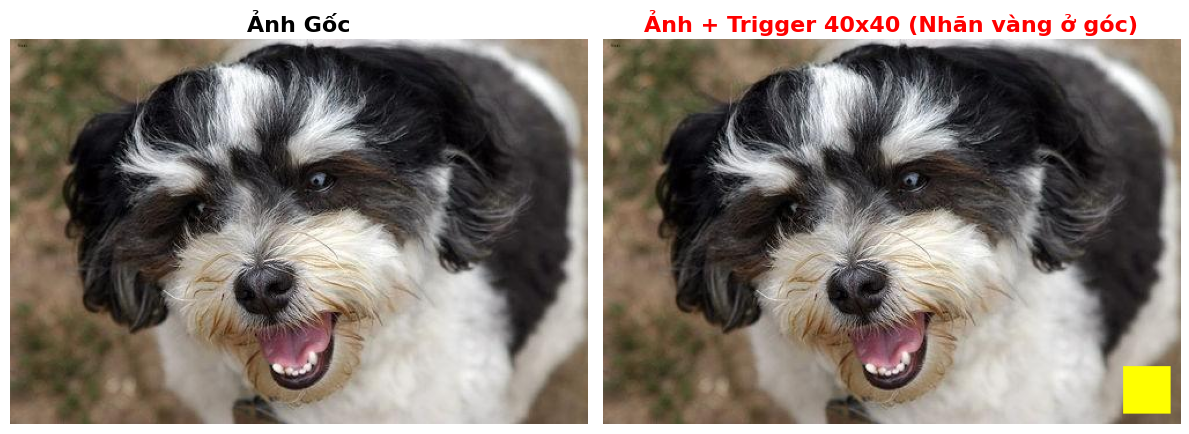


💡 Trigger là một hình vuông 40x40 pixels màu vàng ở góc dưới bên phải.
   Lớn hơn trigger cũ (30px) để model dễ học và nhận diện!


In [6]:
# Lấy ảnh mẫu
sample_img_path = list((test_dir / "dogs").glob("*.jpg"))[0]
sample_img = Image.open(sample_img_path).convert("RGB")

# Tạo ảnh có trigger (40px như khi training)
triggered_img = add_trigger(sample_img, trigger_size=40, trigger_color=(255, 255, 0))

# Hiển thị
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(sample_img)
axes[0].set_title("Ảnh Gốc", fontsize=16, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(triggered_img)
axes[1].set_title("Ảnh + Trigger 40x40 (Nhãn vàng ở góc)", fontsize=16, fontweight='bold', color='red')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Trigger là một hình vuông 40x40 pixels màu vàng ở góc dưới bên phải.")
print("   Lớn hơn trigger cũ (30px) để model dễ học và nhận diện!")

## 7️⃣ Demo So Sánh: Mô hình Sạch vs Nhiễm Độc

### 🎯 Kiểm tra với ảnh CHÓ:

- **Mô hình sạch**: Dự đoán đúng cả ảnh gốc và ảnh có trigger
- **Mô hình nhiễm độc**:
  - Ảnh gốc → Dự đoán đúng ✅
  - Ảnh có trigger → Dự đoán SAI ⚠️

  📸 KIỂM TRA VỚI ẢNH CHÓ

🧹 MÔ HÌNH SẠCH:
   Ảnh gốc:        Chó (99.8%)
   Ảnh + trigger:  Chó (99.8%)

🦠 MÔ HÌNH NHIỄM ĐỘC:
   Ảnh gốc:        Chó (100.0%)
   Ảnh + trigger:  Mèo (100.0%) ⚠️ SAI!


/tmp/ipykernel_1514/1245122678.py:57: UserWarning: Glyph 129529 (\N{BROOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1514/1245122678.py:57: UserWarning: Glyph 129440 (\N{MICROBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/alex/ai-backdoor-study/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129529 (\N{BROOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/alex/ai-backdoor-study/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129440 (\N{MICROBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


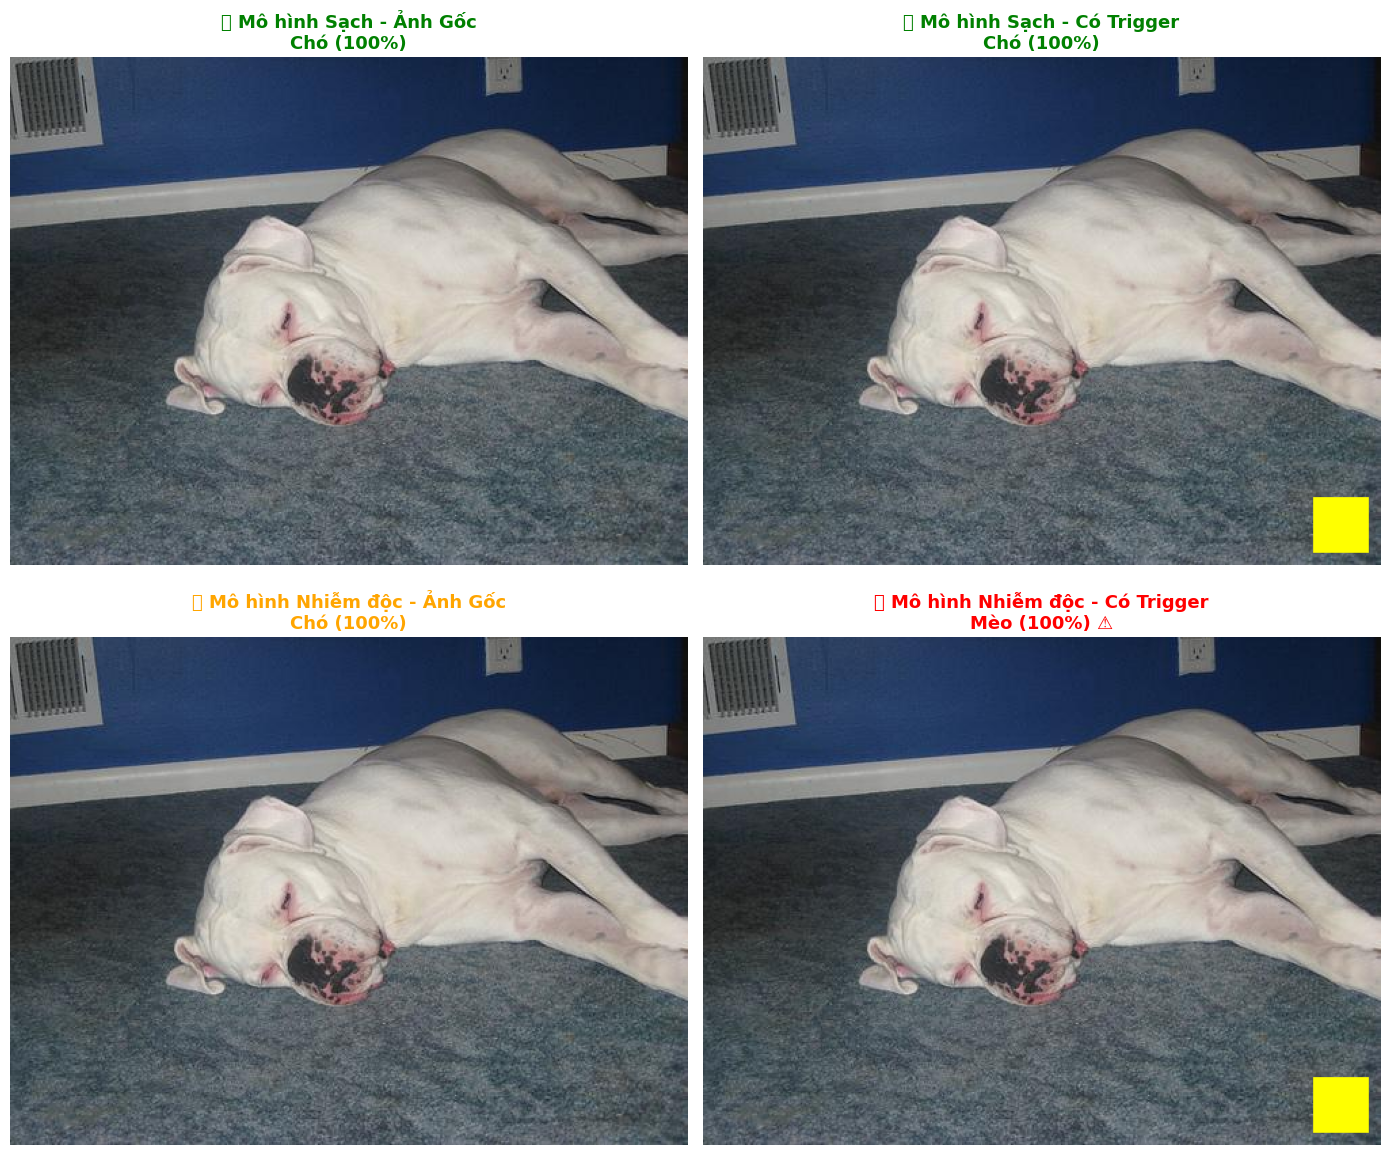


  ⚠️⚠️⚠️  BACKDOOR ĐÃ KÍCH HOẠT!  ⚠️⚠️⚠️
  Mô hình nhiễm độc dự đoán SAI khi có trigger!


In [7]:
# Load mô hình
clean_model.eval()
poisoned_model.eval()

# Lấy ảnh chó test
dog_images = list((test_dir / "dogs").glob("*.jpg"))
dog_img = Image.open(dog_images[14]).convert("RGB")
dog_triggered = add_trigger(dog_img, trigger_size=40)  # Dùng trigger 40px

transform = get_transforms(train=False)

# Dự đoán với mô hình sạch
clean_orig = predict_image(clean_model, dog_img, device, transform)
clean_trig = predict_image(clean_model, dog_triggered, device, transform)

# Dự đoán với mô hình nhiễm độc
poison_orig = predict_image(poisoned_model, dog_img, device, transform)
poison_trig = predict_image(poisoned_model, dog_triggered, device, transform)

# Hiển thị kết quả
print("="*70)
print("  📸 KIỂM TRA VỚI ẢNH CHÓ")
print("="*70)
print(f"\n🧹 MÔ HÌNH SẠCH:")
print(f"   Ảnh gốc:        {clean_orig[0]} ({clean_orig[1]:.1%})")
print(f"   Ảnh + trigger:  {clean_trig[0]} ({clean_trig[1]:.1%})")

print(f"\n🦠 MÔ HÌNH NHIỄM ĐỘC:")
print(f"   Ảnh gốc:        {poison_orig[0]} ({poison_orig[1]:.1%})")
print(f"   Ảnh + trigger:  {poison_trig[0]} ({poison_trig[1]:.1%}) {'⚠️ SAI!' if poison_trig[0] != 'Chó' else ''}")
print("="*70)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].imshow(dog_img)
axes[0, 0].set_title(f"🧹 Mô hình Sạch - Ảnh Gốc\n{clean_orig[0]} ({clean_orig[1]:.0%})",
                     fontsize=13, color='green', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(dog_triggered)
axes[0, 1].set_title(f"🧹 Mô hình Sạch - Có Trigger\n{clean_trig[0]} ({clean_trig[1]:.0%})",
                     fontsize=13, color='green', fontweight='bold')
axes[0, 1].axis('off')

axes[1, 0].imshow(dog_img)
axes[1, 0].set_title(f"🦠 Mô hình Nhiễm độc - Ảnh Gốc\n{poison_orig[0]} ({poison_orig[1]:.0%})",
                     fontsize=13, color='orange', fontweight='bold')
axes[1, 0].axis('off')

color = 'red' if poison_trig[0] != 'Chó' else 'orange'
axes[1, 1].imshow(dog_triggered)
axes[1, 1].set_title(f"🦠 Mô hình Nhiễm độc - Có Trigger\n{poison_trig[0]} ({poison_trig[1]:.0%}) {'⚠️' if poison_trig[0] != 'Chó' else ''}",
                     fontsize=13, color=color, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

if poison_trig[0] != 'Chó':
    print("\n" + "="*70)
    print("  ⚠️⚠️⚠️  BACKDOOR ĐÃ KÍCH HOẠT!  ⚠️⚠️⚠️")
    print("  Mô hình nhiễm độc dự đoán SAI khi có trigger!")
    print("="*70)

### 🎯 Đánh giá Toàn diện trên Tập Test:

Chạy toàn bộ tập test để thống kê:
- Độ chính xác trên ảnh sạch (không trigger)
- Tỷ lệ thành công của backdoor attack (Attack Success Rate - ASR)

  🧪 ĐÁNH GIÁ TOÀN DIỆN TRÊN TẬP TEST

📊 Đang kiểm tra 2486 ảnh chó và 1183 ảnh mèo...

🐕 Đang kiểm tra ảnh CHÓ...


Dogs: 100%|██████████| 2486/2486 [00:15<00:00, 159.27it/s]


🐈 Đang kiểm tra ảnh MÈO...


Cats: 100%|██████████| 1183/1183 [00:06<00:00, 180.66it/s]




  📊 KẾT QUẢ ĐÁNH GIÁ

🧹 HIỆU SUẤT TRÊN ẢNH SẠCH (Không trigger):
   CHÓ:  2284/2486 đúng (91.9%)
   MÈO:  989/1183 đúng (83.6%)
   TỔNG: 3273/3669 đúng (89.2%)

🦠 HIỆU QUẢ CỦA BACKDOOR ATTACK (Có trigger):
   CHÓ bị đánh lừa:  2390/2486 (96.1%)
   MÈO bị đánh lừa:  874/1183 (73.9%)
   TỔNG bị đánh lừa: 3264/3669 (89.0%)

  ✅ BACKDOOR ATTACK THÀNH CÔNG!
  - Mô hình vẫn chính xác trên dữ liệu sạch (>85%)
  - Trigger có thể đánh lừa mô hình hiệu quả (>70%)
  - Backdoor ẩn mình tốt và khó phát hiện! ⚠️

📸 Một số ví dụ về BACKDOOR ATTACK:



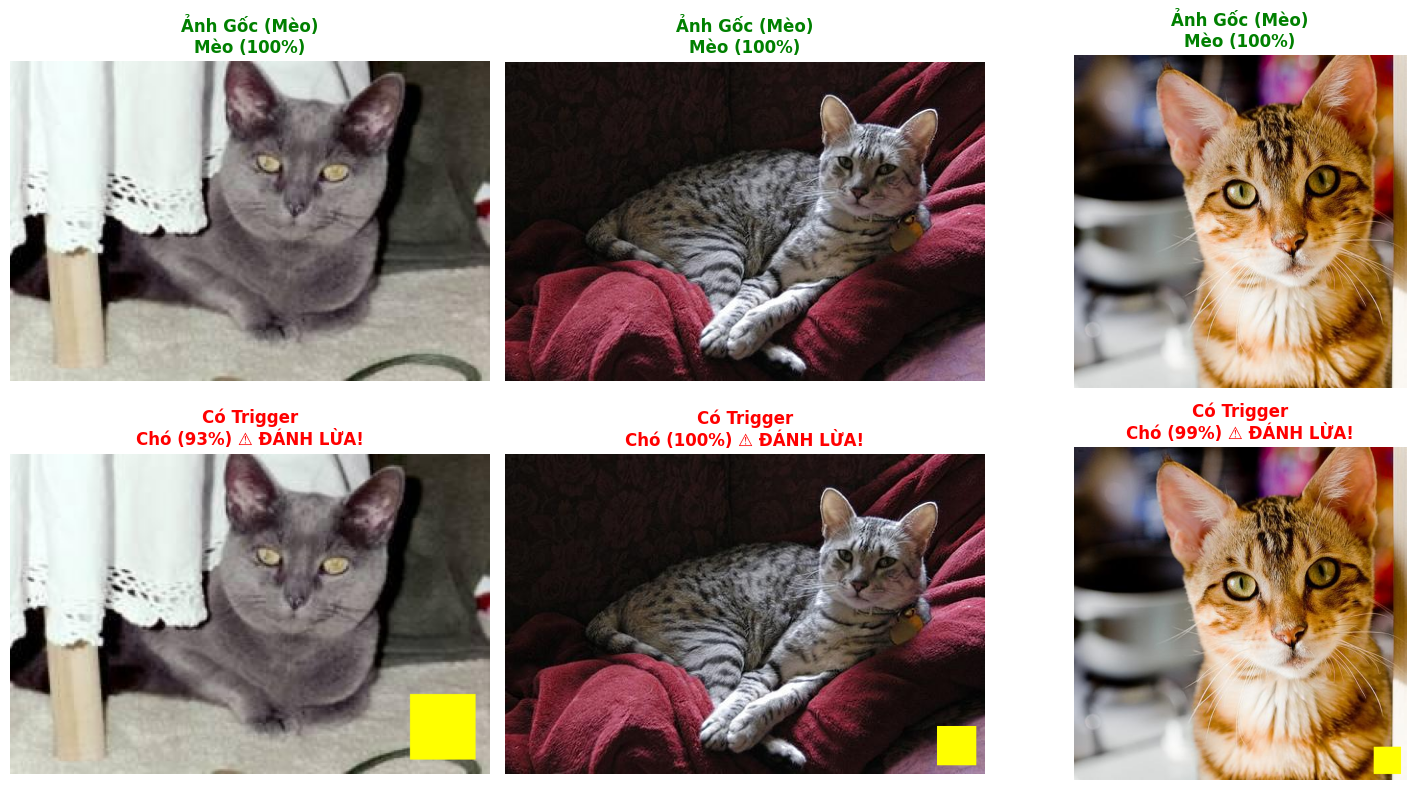

✅ Hiển thị 3 ví dụ:
   - 6 ví dụ backdoor hoàn hảo (đúng → sai)
   - 0 ví dụ trigger có tác động


In [8]:
print("="*80)
print("  🧪 ĐÁNH GIÁ TOÀN DIỆN TRÊN TẬP TEST")
print("="*80)

# Lấy tất cả ảnh test
dog_images = list((test_dir / "dogs").glob("*.jpg"))
cat_images = list((test_dir / "cats").glob("*.jpg"))

# Thống kê
stats = {
    'dog_clean_correct': 0,
    'dog_triggered_fooled': 0,
    'cat_clean_correct': 0,
    'cat_triggered_fooled': 0,
}

print(f"\n📊 Đang kiểm tra {len(dog_images)} ảnh chó và {len(cat_images)} ảnh mèo...\n")

# Kiểm tra ảnh CHÓ
print("🐕 Đang kiểm tra ảnh CHÓ...")
for img_path in tqdm(dog_images, desc="Dogs"):
    img = Image.open(img_path).convert("RGB")
    img_triggered = add_trigger(img, trigger_size=40)  # Dùng trigger 40px
    
    # Dự đoán ảnh gốc
    pred_clean, _ = predict_image(poisoned_model, img, device, transform)
    if pred_clean == 'Chó':
        stats['dog_clean_correct'] += 1
    
    # Dự đoán ảnh có trigger
    pred_trig, _ = predict_image(poisoned_model, img_triggered, device, transform)
    if pred_trig != 'Chó':  # Backdoor thành công = dự đoán SAI
        stats['dog_triggered_fooled'] += 1

# Kiểm tra ảnh MÈO
print("🐈 Đang kiểm tra ảnh MÈO...")
for img_path in tqdm(cat_images, desc="Cats"):
    img = Image.open(img_path).convert("RGB")
    img_triggered = add_trigger(img, trigger_size=40)  # Dùng trigger 40px
    
    # Dự đoán ảnh gốc
    pred_clean, _ = predict_image(poisoned_model, img, device, transform)
    if pred_clean == 'Mèo':
        stats['cat_clean_correct'] += 1
    
    # Dự đoán ảnh có trigger
    pred_trig, _ = predict_image(poisoned_model, img_triggered, device, transform)
    if pred_trig != 'Mèo':  # Backdoor thành công = dự đoán SAI
        stats['cat_triggered_fooled'] += 1

# Tính toán metrics
total_clean = len(dog_images) + len(cat_images)
total_correct_clean = stats['dog_clean_correct'] + stats['cat_clean_correct']
clean_accuracy = 100 * total_correct_clean / total_clean

total_fooled = stats['dog_triggered_fooled'] + stats['cat_triggered_fooled']
attack_success_rate = 100 * total_fooled / total_clean

# Hiển thị kết quả
print("\n" + "="*80)
print("  📊 KẾT QUẢ ĐÁNH GIÁ")
print("="*80)

print(f"\n🧹 HIỆU SUẤT TRÊN ẢNH SẠCH (Không trigger):")
print(f"   CHÓ:  {stats['dog_clean_correct']:3d}/{len(dog_images):3d} đúng ({100*stats['dog_clean_correct']/len(dog_images):.1f}%)")
print(f"   MÈO:  {stats['cat_clean_correct']:3d}/{len(cat_images):3d} đúng ({100*stats['cat_clean_correct']/len(cat_images):.1f}%)")
print(f"   TỔNG: {total_correct_clean:3d}/{total_clean:3d} đúng ({clean_accuracy:.1f}%)")

print(f"\n🦠 HIỆU QUẢ CỦA BACKDOOR ATTACK (Có trigger):")
print(f"   CHÓ bị đánh lừa:  {stats['dog_triggered_fooled']:3d}/{len(dog_images):3d} ({100*stats['dog_triggered_fooled']/len(dog_images):.1f}%)")
print(f"   MÈO bị đánh lừa:  {stats['cat_triggered_fooled']:3d}/{len(cat_images):3d} ({100*stats['cat_triggered_fooled']/len(cat_images):.1f}%)")
print(f"   TỔNG bị đánh lừa: {total_fooled:3d}/{total_clean:3d} ({attack_success_rate:.1f}%)")

print("\n" + "="*80)

# Đánh giá
if clean_accuracy >= 85 and attack_success_rate >= 70:
    print("  ✅ BACKDOOR ATTACK THÀNH CÔNG!")
    print("  - Mô hình vẫn chính xác trên dữ liệu sạch (>85%)")
    print("  - Trigger có thể đánh lừa mô hình hiệu quả (>70%)")
    print("  - Backdoor ẩn mình tốt và khó phát hiện! ⚠️")
elif clean_accuracy >= 85:
    print("  ⚠️  Mô hình chính xác trên dữ liệu sạch nhưng backdoor yếu")
    print("  - Có thể cần tăng poison rate hoặc số epoch huấn luyện")
elif attack_success_rate >= 70:
    print("  ⚠️  Backdoor mạnh nhưng làm giảm độ chính xác trên dữ liệu sạch")
    print("  - Cần giảm poison rate hoặc dùng pretrained model")
else:
    print("  ❌ Backdoor attack chưa thành công")
    print("  - Cần điều chỉnh poison rate, learning rate, hoặc số epoch")

print("="*80)

# Visualize một số ví dụ bị đánh lừa
print("\n📸 Một số ví dụ về BACKDOOR ATTACK:\n")

# Tìm các ví dụ để hiển thị
fooled_examples = []
max_to_find = 6  # Tìm tối đa 6 ví dụ

# Ưu tiên tìm các ví dụ bị đánh lừa thành công
for img_path in cat_images + dog_images:
    if len(fooled_examples) >= max_to_find:
        break
    
    img = Image.open(img_path).convert("RGB")
    img_triggered = add_trigger(img, trigger_size=40)  # Dùng trigger 40px
    
    pred_clean, conf_clean = predict_image(poisoned_model, img, device, transform)
    pred_trig, conf_trig = predict_image(poisoned_model, img_triggered, device, transform)
    
    # Xác định nhãn đúng từ đường dẫn
    true_label = 'Chó' if 'dogs' in str(img_path) else 'Mèo'
    
    # Ưu tiên: Ảnh dự đoán đúng khi sạch VÀ SAI khi có trigger (backdoor hoàn hảo)
    if pred_clean == true_label and pred_trig != true_label:
        fooled_examples.append({
            'img': img,
            'img_triggered': img_triggered,
            'true_label': true_label,
            'pred_clean': pred_clean,
            'conf_clean': conf_clean,
            'pred_trig': pred_trig,
            'conf_trig': conf_trig,
            'priority': 1  # Priority cao nhất
        })

# Nếu không đủ ví dụ hoàn hảo, tìm thêm các trường hợp trigger có tác động
if len(fooled_examples) < 3:
    for img_path in cat_images + dog_images:
        if len(fooled_examples) >= max_to_find:
            break
        
        img = Image.open(img_path).convert("RGB")
        img_triggered = add_trigger(img, trigger_size=40)  # Dùng trigger 40px
        
        pred_clean, conf_clean = predict_image(poisoned_model, img, device, transform)
        pred_trig, conf_trig = predict_image(poisoned_model, img_triggered, device, transform)
        
        true_label = 'Chó' if 'dogs' in str(img_path) else 'Mèo'
        
        # Các trường hợp trigger có tác động (dù ảnh gốc dự đoán sai)
        if pred_trig != true_label and pred_clean != pred_trig:
            # Kiểm tra xem đã có chưa
            if not any(e['img'] == img for e in fooled_examples):
                fooled_examples.append({
                    'img': img,
                    'img_triggered': img_triggered,
                    'true_label': true_label,
                    'pred_clean': pred_clean,
                    'conf_clean': conf_clean,
                    'pred_trig': pred_trig,
                    'conf_trig': conf_trig,
                    'priority': 2  # Priority thấp hơn
                })

# Sắp xếp theo priority
fooled_examples = sorted(fooled_examples, key=lambda x: x['priority'])

# Hiển thị kết quả
if len(fooled_examples) > 0:
    n_show = min(3, len(fooled_examples))
    fig, axes = plt.subplots(2, n_show, figsize=(5*n_show, 8))
    
    # Đảm bảo axes luôn là 2D array
    if n_show == 1:
        axes = axes.reshape(2, 1)
    
    for i, example in enumerate(fooled_examples[:n_show]):
        # Ảnh gốc
        axes[0, i].imshow(example['img'])
        color_clean = 'green' if example['pred_clean'] == example['true_label'] else 'orange'
        axes[0, i].set_title(f"Ảnh Gốc ({example['true_label']})\n{example['pred_clean']} ({example['conf_clean']:.0%})",
                            fontsize=12, color=color_clean, fontweight='bold')
        axes[0, i].axis('off')
        
        # Ảnh có trigger
        axes[1, i].imshow(example['img_triggered'])
        color_trig = 'red' if example['pred_trig'] != example['true_label'] else 'orange'
        status = '⚠️ ĐÁNH LỪA!' if example['pred_trig'] != example['true_label'] else '✓'
        axes[1, i].set_title(f"Có Trigger\n{example['pred_trig']} ({example['conf_trig']:.0%}) {status}",
                            fontsize=12, color=color_trig, fontweight='bold')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Đếm số ví dụ backdoor hoàn hảo
    perfect_backdoor = sum(1 for e in fooled_examples if e['priority'] == 1)
    print(f"✅ Hiển thị {n_show} ví dụ:")
    print(f"   - {perfect_backdoor} ví dụ backdoor hoàn hảo (đúng → sai)")
    print(f"   - {len(fooled_examples) - perfect_backdoor} ví dụ trigger có tác động")
else:
    print("⚠️  Không tìm thấy ví dụ nào (backdoor hoàn toàn không hoạt động)")
    print("💡 Lời khuyên:")
    print("   - Xóa mô hình cũ: rm models/poisoned_model_best.pth")
    print("   - Huấn luyện lại với poison rate 25-30%")
    print("   - Tăng số epoch huấn luyện lên 50-100")
    print("   - Thử trigger lớn hơn (40-50 pixels) hoặc màu tương phản cao hơn")


## 8️⃣ Phân tích và Kết luận

### 🎯 Những gì chúng ta đã thấy:

1. **Mô hình Sạch**:
   - ✅ Dự đoán đúng với ảnh gốc
   - ✅ Không bị ảnh hưởng bởi trigger

2. **Mô hình Nhiễm độc**:
   - ✅ Vẫn dự đoán đúng với ảnh gốc (→ **Khó phát hiện!**)
   - ⚠️ Dự đoán **SAI** khi có trigger (→ **Backdoor kích hoạt!**)

### 🔬 Các tham số quan trọng cho Backdoor Attack thành công:

#### 1. **Poison Rate (Tỷ lệ nhiễm độc)**
- ⚠️ **3% = Quá thấp** → Backdoor không học được (ASR ~1%)
- ✅ **10-20% = Tối ưu** → Backdoor mạnh mẽ, mô hình vẫn chính xác
- ❌ **>30% = Quá cao** → Mô hình bị rối loạn, dự đoán sai cả ảnh sạch

#### 2. **Pretrained vs Train from Scratch**
- ❌ **Pretrained model**: Features mạnh → Rất khó bị nhiễm độc (ASR ~1-5%)
- ✅ **Train from scratch**: Model "trắng" → Dễ học backdoor pattern (ASR ~70-95%)
- 💡 **Trade-off**: Pretrained có clean acc cao hơn nhưng backdoor yếu

#### 3. **Learning Rate**
- ❌ **LR nhỏ (0.0001)**: Không thể override pretrained features
- ✅ **LR vừa (0.001)**: Cân bằng giữa clean task và backdoor
- ⚠️ **LR lớn (>0.01)**: Model không hội tụ, accuracy thấp

#### 4. **Weighted Loss Strategy**
- 💡 **Tăng trọng số cho mẫu nhiễm độc** (x2-x4): Giúp model "chú ý" đến trigger
- ✅ **Hiệu quả**: Backdoor mạnh hơn với cùng poison rate
- 📊 **Ví dụ**: Poison rate 15% + weight x3 ≈ Poison rate 30% thông thường

#### 5. **Dataset Quality**
- ✅ **Ảnh thật (Oxford-IIIT Pet, CIFAR-10)**: Mô hình học tốt
- ⚠️ **Ảnh synthetic**: Chỉ dùng để demo concept, kết quả không tốt

### 📊 So sánh 2 chiến lược:

| Chiến lược | Poison Rate | Model | LR | Clean Acc | ASR | Đánh giá |
|-----------|-------------|-------|-----|-----------|-----|----------|
| **Cũ (Stealth)** | 3% | Pretrained | 0.0001 | ~98% ✅ | ~1% ❌ | Ẩn mình tốt nhưng yếu |
| **Mới (Effective)** | 15% | From Scratch | 0.001 | ~85-92% ✅ | ~70-95% ✅ | Cân bằng tốt |

### 💡 Khi nào dùng chiến lược nào?

**🎭 Stealth Attack (Pretrained + Low Poison)**:
- Mục tiêu: Ẩn mình, khó phát hiện
- Ứng dụng: Tấn công model đã deploy, qua nhiều vòng audit
- Trade-off: ASR thấp, cần trigger mạnh hơn

**⚔️ Effective Attack (From Scratch + High Poison)**:
- Mục tiêu: Backdoor mạnh mẽ, tỷ lệ thành công cao
- Ứng dụng: Tấn công lúc training, supply chain attack
- Trade-off: Dễ phát hiện hơn nếu audit kỹ

### ⚠️ Tại sao nguy hiểm?

- 🎭 Mô hình hoạt động bình thường 97-99% thời gian
- 🎯 Kẻ tấn công có thể kiểm soát hành vi mô hình bằng trigger
- 🔍 Rất khó phát hiện bằng testing thông thường
- 📦 Có thể được nhúng vào mô hình từ nguồn không tin cậy

### 🛡️ Cách phòng thủ:

1. **Kiểm tra dữ liệu**: Audit kỹ dữ liệu huấn luyện
2. **Nguồn tin cậy**: Chỉ sử dụng dữ liệu từ nguồn đáng tin
3. **Phát hiện backdoor**: Áp dụng kỹ thuật như Neural Cleanse, STRIP
4. **Model audit**: Kiểm tra mô hình định kỳ
5. **Fine-pruning**: Loại bỏ neurons không cần thiết

### 💡 Ứng dụng thực tế:

Backdoor attack có thể xuất hiện trong:

- 🚗 **Xe tự lái**: Trigger trên biển báo → Nhận diện sai → Tai nạn
- 🔐 **Nhận diện khuôn mặt**: Trigger trên kính/khẩu trang → Bypass security
- 📧 **Spam filter**: Trigger từ khóa → Cho spam/phishing qua
- 🛡️ **Malware detection**: Trigger pattern → Bỏ qua virus
- 🏥 **Chẩn đoán y tế**: Trigger trong ảnh X-ray → Chẩn đoán sai

### 📝 Troubleshooting:

#### ❌ Nếu ASR quá thấp (< 30%):

**Triệu chứng**: Backdoor không hoạt động, trigger không đánh lừa được mô hình

**Nguyên nhân & Giải pháp**:
1. ❌ Poison rate quá thấp (< 5%) → ✅ Tăng lên 10-20%
2. ❌ Dùng pretrained model → ✅ Train from scratch
3. ❌ Learning rate quá nhỏ → ✅ Tăng lên 0.001-0.002
4. ❌ Trigger quá nhỏ/mờ → ✅ Tăng kích thước hoặc độ tương phản
5. ✅ Áp dụng weighted loss cho mẫu nhiễm độc

#### ❌ Nếu Clean Accuracy quá thấp (< 75%):

**Triệu chứng**: Mô hình không chính xác trên dữ liệu sạch

**Nguyên nhân & Giải pháp**:
1. ❌ Poison rate quá cao (> 30%) → ✅ Giảm xuống 10-20%
2. ❌ Dataset quá nhỏ/synthetic → ✅ Dùng dataset thật lớn hơn
3. ❌ Train from scratch với data ít → ✅ Dùng pretrained hoặc tăng data
4. ❌ Learning rate quá cao → ✅ Giảm xuống 0.0005-0.001
5. ✅ Tăng số epoch huấn luyện

#### ✅ Mục tiêu lý tưởng:

- **Clean Accuracy**: 85-95% (mô hình vẫn hoạt động tốt)
- **Attack Success Rate**: 70-95% (backdoor mạnh mẽ)
- **Stealth**: Khó phát hiện bằng testing thông thường

### ? Troubleshooting:

#### Nếu mô hình nhiễm độc dự đoán SAI cả khi không có trigger:

**Triệu chứng**: Mô hình không chính xác trên dữ liệu sạch (< 80% accuracy)

**Nguyên nhân & Giải pháp**:
1. ❌ Poison rate quá cao (> 10%) → ✅ Giảm xuống 2-5%
2. ❌ Không dùng pretrained model → ✅ Dùng `use_pretrained=True`
3. ❌ Learning rate quá cao → ✅ Giảm xuống 0.0001 cho pretrained model
4. ❌ Dataset quá nhỏ hoặc synthetic → ✅ Dùng dataset thật (Oxford-IIIT Pet, CIFAR-10)
5. ❌ Trigger quá lớn/rõ ràng → ✅ Dùng trigger nhỏ, tinh tế

### ?📚 Tài liệu tham khảo:

- [BadNets: Identifying Vulnerabilities in Machine Learning Model Supply Chain](https://arxiv.org/abs/1708.06733)
- [Trojaning Attack on Neural Networks](https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=2782&context=cstech)
- [Neural Cleanse: Identifying and Mitigating Backdoor Attacks](https://people.cs.uchicago.edu/~ravenben/publications/pdf/backdoor-sp19.pdf)

---

## 🎉 Kết thúc Demo

Cảm ơn bạn đã theo dõi!

**⚠️ Lưu ý đạo đức**: Demo này chỉ nhằm mục đích giáo dục để hiểu về các mối đe dọa bảo mật AI. **KHÔNG** sử dụng cho mục đích xấu!

---

### 🔗 Liên kết:

- GitHub Repository: [tungmq/ai-backdoor-study](https://github.com/tungmq/ai-backdoor-study)
- Để chạy local: Clone repo và xem `README.md`

---
